<div class="usecase-title">Enhancing Job Accessibility and Opportunities in Melbourne</div>
<div class="usecase-authors"><b>Authored by: </b> Tharaka Sandamal And Sahan Chamod</div>

<div class="usecase-duration"><b>Duration:</b> 180 mins</div>
<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data Analysis, Pandas, Data Visualisation</div>


<div class="usecase-section-header">Scenario</div>

# Use Case Summary: Job Accessibility Analysis in Melbourne

### Scenario

Melbourne displays significant variation in spatial job accessibility, which impacts economic opportunities and social inclusion. Effective planning requires a holistic understanding of how employment locations, public transport availability, and commercial infrastructure interact across the city. However, current decision-making often lacks unified spatial analysis, making it challenging to strategically address transport gaps in high-demand employment areas.

---

### Project Objective

The objective of this project is to evaluate and improve job accessibility in Melbourne by integrating employment density, transport stop coverage, and commercial floor space. The project focuses on identifying areas where transport access is insufficient relative to job and business activity, using both rule-based and machine learning-driven approaches.

---

### Project Stages

#### Stage 1: Data Collection & Integration

- Collect datasets from:
  - Employment by Block by CLUE Industry (2023)
  - Bus and Tram Stops from City of Melbourne open data
  - Floor Space by Use by Block (2023)
  - CLUE Block Boundaries (GeoJSON format)

- Preprocess data by validating geometries, aligning coordinate reference systems, handling missing values, and performing spatial joins to merge datasets into a unified format for analysis.

#### Stage 2: Exploratory Data Analysis (EDA)

- Analyse employment distribution across city blocks and CLUE small areas.
- Explore floor space patterns to understand commercial concentration and potential business zones.
- Visualise spatial distribution of bus and tram stops using interactive maps with marker clustering.
- Aggregate transport stop counts per block and compute basic ratios to assess coverage.

#### Stage 3: Spatial Accessibility Analysis

- Compute transport-to-worker and transport-to-space ratios to quantify accessibility at the block level.
- Visualise accessibility metrics using choropleth maps and interactive GeoJSON-based mapping.
- Apply **rule-based filtering** to identify blocks with high demand (jobs or space) but low accessibility ratios.
- Integrate **machine learning clustering (KMeans)** to classify blocks into accessibility levels: Low, Medium, and High.
- Generate an interactive final map displaying cluster labels, block information, and transport overlays to communicate accessibility insights clearly.

#### Stage 4: Visualisation and Dashboard Development

- Develop interactive folium-based maps with informative tooltips showing block ID, CLUE area, transport stops, worker and space ratios, and cluster level.
- Use marker clusters to display bus and tram stop locations for layered analysis.
- Implement a customised legend and colour scheme to represent accessibility tiers clearly.
- Ensure maps are interactive and suitable for stakeholder presentations and urban planning use.

#### Stage 5: Recommendations and Strategic Planning

- Identify blocks in **Low Accessibility (Cluster 0)** that show high commercial floor space or employment potential.
- Recommend prioritisation of transport infrastructure enhancements in these blocks.
- Highlight blocks with high accessibility but under-utilised space as candidates for business development and employment programs.
- Suggest expansion by incorporating train network data and real-time flows for future analysis stages.

---

### Expected Outcomes

- Deliver a complete spatial model highlighting job accessibility gaps.
- Enable data-driven decisions for infrastructure planning and economic development.
- Guide resource allocation by pinpointing priority blocks for intervention.
- Present an expandable methodology that supports ongoing monitoring and refinement of accessibility planning.

---

### 1. Employment by Block by CLUE Industry (2002–2023)

- Contains employment data showing job counts per city block, categorised by industry and small area allocation.
- Valuable for analysing spatial job density, sectoral employment patterns, and long-term trends.
- **Link:** [Employment by Block by CLUE Industry](https://data.melbourne.vic.gov.au/explore/dataset/employment-by-block-by-clue-industry/information/?disjunctive.clue_small_area&disjunctive.block_id)

---

### 2. Metro Train Stations with Accessibility Information

- Details the locations of metro train stations along with accessibility features.
- Crucial for evaluating public transport coverage and accessibility to employment areas.
- **Link:** [Metro Train Stations with Accessibility Information](https://data.melbourne.vic.gov.au/explore/dataset/metro-train-stations-with-accessibility-information/table/)

---

### 3. Bus Stops

- Provides geospatial locations of bus stops across Melbourne.
- Important for assessing bus network coverage and accessibility gaps relative to employment opportunities.
- **Link:** [Bus Stops](https://data.melbourne.vic.gov.au/explore/dataset/bus-stops/information/)

---

### 4. Floor Space by Use by Block (2002–2023)

- Offers data on floor space usage categorised by type (commercial, office, retail, etc.) and city block.
- Useful for determining business concentration, commercial capacity, and potential for employment growth.
- **Link:** [Floor Space by Use by Block](https://data.melbourne.vic.gov.au/explore/dataset/floor-space-by-use-by-block/information/)

---

### 5. City Circle Tram Stops

- Provides geospatial data on the stops of the City Circle tram service operating within Melbourne's central business district.
- Essential for analysing tram network coverage, especially in the CBD, and assessing accessibility to key employment and tourist areas.
- **Link:** [City Circle Tram Stops](https://data.melbourne.vic.gov.au/explore/dataset/city-circle-tram-stops/)





### Package/Library Imports

## IMPORT LIBRARIES

In [ ]:
# General purpose libraries
import numpy as np
import pandas as pd
from io import StringIO
import requests
import json

# Configuration
from config import API_KEY  # Securely import API key

# Geospatial processing
import geopandas as gpd
from shapely.geometry import Point, shape

# Visualisation
import matplotlib.pyplot as plt
import folium
from folium import Choropleth
from folium.plugins import MarkerCluster
from folium.features import GeoJson, GeoJsonTooltip

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


### Read data using API

In [2]:
#from config import API_KEY  # Import API key securely


# Preferred Method: Export Endpoint

# Function to collect data from the City of Melbourne Open Data API
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'
    url = f'{base_url}{dataset_id}/exports/{format}'
    
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC'
        #'api_key': API_KEY  # use if datasets require API key permissions
    }

    # GET request
    response = requests.get(url, params=params)
    if response.status_code == 200:
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset 
    else:
        print(f'Request failed with status code {response.status_code}')

# Read data using the function
#transport_df = collect_data('metro-train-stations-with-accessibility-information')
emp_block_df = collect_data('employment-by-block-by-clue-industry')
block_df = collect_data('blocks-for-census-of-land-use-and-employment-clue')
Bus_df = collect_data('bus-stops')
floor_df = collect_data('floor-space-by-use-by-block')
tram_df = collect_data('city-circle-tram-stops')
clue_areas_df = collect_data('small-areas-for-census-of-land-use-and-employment-clue')


## Step 1.2: Data Inspection 

### Employment by Block by CLUE Industry

In [3]:
# Preview the dataset
print("First 5 records:")
display(emp_block_df.head())

# Check shape and column names
print("Shape:", emp_block_df.shape)
print("\nColumn Names:")
print(emp_block_df.columns.tolist())

# Check data types
print("\nData Types:")
print(emp_block_df.dtypes)

# Check for missing values
print("\nMissing Values:")
print(emp_block_df.isnull().sum())


# Get unique industries if present
if 'industry' in emp_block_df.columns:
    print("\nUnique Industries:")
    print(emp_block_df['industry'].unique())



First 5 records:


census_year  block_id  clue_small_area  accommodation  \
0         2023         6  Melbourne (CBD)            0.0   
1         2023        11  Melbourne (CBD)          187.0   
2         2023        12  Melbourne (CBD)           32.0   
3         2023        14  Melbourne (CBD)          124.0   
4         2023        15  Melbourne (CBD)           75.0   

   admin_and_support_services  agriculture_and_mining  \
0                         0.0                     0.0   
1                        40.0                     0.0   
2                         NaN                     0.0   
3                       167.0                     NaN   
4                       103.0                     NaN   

   arts_and_recreation_services  business_services  construction  \
0                         203.0                0.0           0.0   
1                           NaN              182.0           NaN   
2                           NaN             1525.0           0.0   
3                          15.0              550.0           NaN   
4                         149.0              120.0           NaN   

   education_and_training  ...  information_media_and_telecommunications  \
0                     0.0  ...                                       NaN   
1                     0.0  ...                                       NaN   
2                   379.0  ...                                       NaN   
3                   292.0  ...                                      19.0   
4                   253.0  ...                                      73.0   

   manufacturing  other_services  public_administration_and_safety  \
0            0.0             NaN                               0.0   
1            0.0            36.0                               0.0   
2            0.0            21.0                               NaN   
3            NaN           165.0                              23.0   
4           24.0           220.0                               NaN   

   real_estate_services  rental_and_hiring_services  retail_trade  \
0                   NaN                         0.0          47.0   
1                  42.0                         0.0          14.0   
2                   NaN                         0.0          11.0   
3                  53.0                         0.0          44.0   
4                   NaN                         0.0         266.0   

   transport_postal_and_storage  wholesale_trade  total_jobs_in_block  
0                           0.0              0.0                647.0  
1                           NaN              0.0                759.0  
2                           NaN              0.0               4087.0  
3                           NaN             33.0               2049.0  
4                           NaN              NaN               1833.0  

[5 rows x 24 columns]

Shape: (13000, 24)

Column Names:
['census_year', 'block_id', 'clue_small_area', 'accommodation', 'admin_and_support_services', 'agriculture_and_mining', 'arts_and_recreation_services', 'business_services', 'construction', 'education_and_training', 'electricity_gas_water_and_waste_services', 'finance_and_insurance', 'food_and_beverage_services', 'health_care_and_social_assistance', 'information_media_and_telecommunications', 'manufacturing', 'other_services', 'public_administration_and_safety', 'real_estate_services', 'rental_and_hiring_services', 'retail_trade', 'transport_postal_and_storage', 'wholesale_trade', 'total_jobs_in_block']

Data Types:
census_year                                   int64
block_id                                      int64
clue_small_area                              object
accommodation                               float64
admin_and_support_services                  float64
agriculture_and_mining                      float64
arts_and_recreation_services   

In [4]:
print("First 5 records:")
display(block_df.head())


First 5 records:


geo_point_2d  \
0   -37.788517214796904, 144.9421522923356   
1    -37.78752314475404, 144.9428068448982   
2   -37.78035632811396, 144.94536433435934   
3   -37.80720183148242, 144.94336441344424   
4  -37.806706331914484, 144.94240782994808   

                                           geo_shape  block_id  \
0  {"coordinates": [[[144.9421360326, -37.7875659...       925   
1  {"coordinates": [[[144.9421360326, -37.7875659...       924   
2  {"coordinates": [[[144.9425926939, -37.7787229...       930   
3  {"coordinates": [[[144.9427148261, -37.8073238...       412   
4  {"coordinates": [[[144.9427148261, -37.8073238...       410   

                      clue_area  
0                     Parkville  
1                     Parkville  
2                     Parkville  
3  West Melbourne (Residential)  
4  West Melbourne (Residential)

### City Circle tram stops

In [5]:
tram_df.head()

# Preview City Circle Tram Stops dataset
print("First 5 records:")
display(tram_df.head())

# Check shape and column names
print("Shape:", tram_df.shape)

print("\nColumn Names:")
print(tram_df.columns.tolist())

# Data types
print("\nData Types:")
print(tram_df.dtypes)

# Missing values
print("\nMissing Values:")
print(tram_df.isnull().sum())



First 5 records:


geo_point_2d  \
0   -37.82023778673241, 144.95786314283018   
1   -37.82097269970027, 144.95546153614245   
2   -37.82190465062153, 144.95109855638137   
3  -37.811771476718356, 144.95644059700524   
4   -37.81105928060848, 144.95891745116262   

                                           geo_shape  \
0  {"coordinates": [144.95786314283018, -37.82023...   
1  {"coordinates": [144.95546153614245, -37.82097...   
2  {"coordinates": [144.95109855638137, -37.82190...   
3  {"coordinates": [144.95644059700524, -37.81177...   
4  {"coordinates": [144.95891745116262, -37.81105...   

                                   name      xorg stop_no  mccid_str  xsource  \
0  Melbourne Aquarium / Flinders Street  GIS Team       2        NaN  Mapbase   
1      Spencer Street / Flinders Street  GIS Team       1        NaN  Mapbase   
2       The Goods Shed / Wurundjeri Way  GIS Team      D5        NaN  Mapbase   
3      William Street / La Trobe Street  GIS Team       3        NaN  Mapbase   
4        Queen Street / La Trobe Street  GIS Team       4        NaN  Mapbase   

        xdate  mccid_int  
0  2011-10-18          4  
1  2011-10-18          5  
2  2011-10-18          7  
3  2011-10-18         16  
4  2011-10-18         17

Shape: (28, 9)

Column Names:
['geo_point_2d', 'geo_shape', 'name', 'xorg', 'stop_no', 'mccid_str', 'xsource', 'xdate', 'mccid_int']

Data Types:
geo_point_2d     object
geo_shape        object
name             object
xorg             object
stop_no          object
mccid_str       float64
xsource          object
xdate            object
mccid_int         int64
dtype: object

Missing Values:
geo_point_2d     0
geo_shape        0
name             0
xorg             0
stop_no          0
mccid_str       28
xsource          0
xdate            0
mccid_int        0
dtype: int64


## Bus Stops

In [6]:
# Preview Bus Stops dataset
print("First 5 records:")
display(Bus_df.head())

# Check shape and column names
print("Shape:", Bus_df.shape)
print("\nColumn Names:")
print(Bus_df.columns.tolist())

# Data types
print("\nData Types:")
print(Bus_df.dtypes)

# Missing values
print("\nMissing Values:")
print(Bus_df.isnull().sum())


First 5 records:


geo_point_2d  \
0   -37.81842481335676, 144.96889648633675   
1   -37.81767597164006, 144.95888238475013   
2   -37.78188915501449, 144.95963193312105   
3  -37.793726533289785, 144.94716743007305   
4   -37.80286165064241, 144.92778487963457   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.96889648633675, -37.81842...   573333   29.149053   
1  {"coordinates": [144.95888238475013, -37.81767...        0   10.537902   
2  {"coordinates": [144.95963193312105, -37.78188...        0   25.269643   
3  {"coordinates": [144.94716743007305, -37.79372...        0   44.230506   
4  {"coordinates": [144.92778487963457, -37.80286...        0   67.718553   

   addressp_1 asset_clas               asset_type  objectid   str_id  \
0         288    Signage  Sign - Public Transport       749  1249454   
1         105    Signage  Sign - Public Transport      2098  1247042   
2         212    Signage  Sign - Public Transport      2143  1252383   
3         237    Signage  Sign - Public Transport      2627  1249788   
4         360    Signage  Sign - Public Transport      3306  1235311   

   addresspt  asset_subt                       model_desc   mcc_id  \
0     606816         NaN  Sign - Public Transport 1 Panel  1249454   
1     507646         NaN  Sign - Public Transport 1 Panel  1247042   
2     108510         NaN  Sign - Public Transport 1 Panel  1252383   
3     100087         NaN  Sign - Public Transport 1 Panel  1249788   
4     103002         NaN  Sign - Public Transport 1 Panel  1235311   

   roadseg_id                                        descriptio model_no  
0           0  Sign - Public Transport 1 Panel Bus Stop Type 12     P.16  
1       20118   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
2       22387   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
3       20919   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16  
4       21680  Sign - Public Transport 1 Panel Bus Stop Type 13     P.16

Shape: (309, 16)

Column Names:
['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 'asset_subt', 'model_desc', 'mcc_id', 'roadseg_id', 'descriptio', 'model_no']

Data Types:
geo_point_2d     object
geo_shape        object
prop_id           int64
addresspt1      float64
addressp_1        int64
asset_clas       object
asset_type       object
objectid          int64
str_id            int64
addresspt         int64
asset_subt      float64
model_desc       object
mcc_id            int64
roadseg_id        int64
descriptio       object
model_no         object
dtype: object

Missing Values:
geo_point_2d      0
geo_shape         0
prop_id           0
addresspt1        0
addressp_1        0
asset_clas        0
asset_type        0
objectid          0
str_id            0
addresspt         0
asset_subt      309
model_desc        0
mcc_id            0
roadseg_id        0
descriptio        0
model_no          0
dtype: int

### Floor Space by Use by Block

In [7]:
# Preview floor space dataset
print("First 5 records:")
display(floor_df.head())

# Check shape and columns
print("Shape:", floor_df.shape)
print("\nColumn Names:")
print(floor_df.columns.tolist())

# Data types
print("\nData Types:")
print(floor_df.dtypes)

# Missing values
print("\nMissing Values:")
print(floor_df.isnull().sum())


First 5 records:


census_year  block_id clue_small_area  commercial_accommodation  \
0         2007       527      Kensington                       0.0   
1         2007       529      Kensington                       0.0   
2         2007       534      Kensington                       0.0   
3         2007       539      Kensington                       0.0   
4         2007       542      Kensington                       0.0   

   common_area  community_use  educational_research  \
0          NaN            0.0                   0.0   
1          0.0            0.0                   0.0   
2          0.0            0.0                   0.0   
3          0.0            0.0                   0.0   
4          0.0            0.0                   0.0   

   entertainment_recreation_indoor  equipment_installation  hospital_clinic  \
0                              0.0                     0.0              0.0   
1                              0.0                     0.0              0.0   
2                              0.0                     0.0              0.0   
3                              0.0                     0.0              0.0   
4                              0.0                     0.0              0.0   

   ...  transport  transport_storage_uncovered  unoccupied_under_construction  \
0  ...        0.0                          0.0                            0.0   
1  ...        0.0                          0.0                            0.0   
2  ...        0.0                          0.0                            0.0   
3  ...        0.0                          0.0                            0.0   
4  ...        0.0                          0.0                            0.0   

   unoccupied_under_demolition_condemned  unoccupied_under_renovation  \
0                                    0.0                          0.0   
1                                    0.0                          0.0   
2                                    0.0                          0.0   
3                                    0.0                          0.0   
4                                    0.0                          0.0   

   unoccupied_undeveloped_site  unoccupied_unused  wholesale  workshop_studio  \
0                          NaN                0.0        0.0              0.0   
1                          NaN                0.0        0.0              0.0   
2                          0.0                0.0        0.0              0.0   
3                          NaN                NaN        0.0              0.0   
4                          0.0                0.0        0.0              0.0   

   total_floor_space_in_block  
0                     21138.0  
1                     10098.0  
2                         NaN  
3                     49600.0  
4                      1735.0  

[5 rows x 41 columns]

Shape: (13000, 41)

Column Names:
['census_year', 'block_id', 'clue_small_area', 'commercial_accommodation', 'common_area', 'community_use', 'educational_research', 'entertainment_recreation_indoor', 'equipment_installation', 'hospital_clinic', 'house_townhouse', 'institutional_accommodation', 'manufacturing', 'office', 'park_reserve', 'parking_commercial_covered', 'parking_commercial_uncovered', 'parking_private_covered', 'parking_private_uncovered', 'performances_conferences_ceremonies', 'private_outdoor_space', 'public_display_area', 'residential_apartment', 'retail_cars', 'retail_shop', 'retail_showroom', 'retail_stall', 'sports_and_recreation_outdoor', 'square_promenade', 'storage', 'student_accommodation', 'transport', 'transport_storage_uncovered', 'unoccupied_under_construction', 'unoccupied_under_demolition_condemned', 'unoccupied_under_renovation', 'unoccupied_undeveloped_site', 'unoccupied_unused', 'wholesale', 'workshop_studio', 'total_floor_space_in_block']

Data Types:
ce

### Preparing CLUE Block Dataset for Mapping

- The dataset includes polygon shapes for each CLUE block area.
- These polygons are converted into a GeoDataFrame for spatial visualisation and joining.



In [8]:
# Import necessary modules
#from shapely.geometry import shape
#import json

# Convert 'geo_shape' column into actual geometry
block_df['geometry'] = block_df['geo_shape'].apply(lambda x: shape(json.loads(x)))

# Convert to GeoDataFrame
block_gdf = gpd.GeoDataFrame(block_df, geometry='geometry')
block_gdf.set_crs(epsg=4326, inplace=True)

# Preview
print("Block Geodata - Remaining missing values:", block_gdf.isnull().sum().sum())
block_gdf.head()


Block Geodata - Remaining missing values: 0


geo_point_2d  \
0   -37.788517214796904, 144.9421522923356   
1    -37.78752314475404, 144.9428068448982   
2   -37.78035632811396, 144.94536433435934   
3   -37.80720183148242, 144.94336441344424   
4  -37.806706331914484, 144.94240782994808   

                                           geo_shape  block_id  \
0  {"coordinates": [[[144.9421360326, -37.7875659...       925   
1  {"coordinates": [[[144.9421360326, -37.7875659...       924   
2  {"coordinates": [[[144.9425926939, -37.7787229...       930   
3  {"coordinates": [[[144.9427148261, -37.8073238...       412   
4  {"coordinates": [[[144.9427148261, -37.8073238...       410   

                      clue_area  \
0                     Parkville   
1                     Parkville   
2                     Parkville   
3  West Melbourne (Residential)   
4  West Melbourne (Residential)   

                                            geometry  
0  POLYGON ((144.94214 -37.78757, 144.941 -37.788...  
1  POLYGON ((144.94214 -37.78757, 144.94319 -37.7...  
2  POLYGON ((144.94259 -37.77872, 144.94202 -37.7...  
3  POLYGON ((144.94271 -37.80732, 144.9437 -37.80...  
4  POLYGON ((144.94271 -37.80732, 144.94285 -37.8...

## Step 1.3: Data Cleaning 

### Employment Dataset – Handle Missing Values and Recalculate Totals


- Missing values in job sector columns are assumed to represent zero jobs.
- Fill them with 0 and recalculate the total number of jobs in each block.

In [9]:
# Fill missing job sector values with 0
emp_block_df.fillna(0, inplace=True)

# Recalculate total jobs in block from individual sectors
sector_columns = emp_block_df.columns[3:-1]
emp_block_df['total_jobs_in_block'] = emp_block_df[sector_columns].sum(axis=1)

# Confirm all missing values are handled
print("Employment Data - Remaining missing values:", emp_block_df.isnull().sum().sum())


Employment Data - Remaining missing values: 0


### Cleaning Metro Train Stations Dataset

- Split the `geo_point_2d` column into `latitude` and `longitude`.
- Convert the dataset into a GeoDataFrame for spatial analysis and mapping.

In [10]:
#from shapely.geometry import Point
#import geopandas as gpd

# Extract latitude and longitude
tram_df[['latitude', 'longitude']] = tram_df['geo_point_2d'].str.split(',', expand=True).astype(float)

# Convert into GeoDataFrame
tram_geometry = [Point(xy) for xy in zip(tram_df['longitude'], tram_df['latitude'])]
tram_gdf = gpd.GeoDataFrame(tram_df, geometry=tram_geometry)
tram_gdf.set_crs(epsg=4326, inplace=True)

# Check missing values
print("City Circle Tram Stops Data - Remaining missing values:", tram_gdf.isnull().sum().sum())


City Circle Tram Stops Data - Remaining missing values: 28




- Only `mccid_str` has missing values in all records.
- Since `mccid_int` is complete and likely sufficient, `mccid_str` is safely dropped to avoid redundancy.


In [11]:
# Drop the redundant column with all missing values
tram_df.drop(columns=['mccid_str'], inplace=True)

# Confirm remaining missing values
print("City Circle Tram Stops Data – Remaining missing values:", tram_df.isnull().sum().sum())


City Circle Tram Stops Data – Remaining missing values: 0


### Cleaning Bus Stops Dataset

- Coordinates are split from the `geo_point_2d` field.
- Data is converted into a GeoDataFrame with EPSG:4326 CRS for mapping.

In [12]:
# Extract latitude and longitude
Bus_df[['latitude', 'longitude']] = Bus_df['geo_point_2d'].str.split(',', expand=True).astype(float)

# Create GeoDataFrame
bus_geometry = [Point(xy) for xy in zip(Bus_df['longitude'], Bus_df['latitude'])]
bus_gdf = gpd.GeoDataFrame(Bus_df, geometry=bus_geometry)
bus_gdf.set_crs(epsg=4326, inplace=True)

# Preview
bus_gdf.head()

print("Bus Stops Data - Remaining missing values:", bus_gdf.isnull().sum().sum())

Bus Stops Data - Remaining missing values: 309


Check Column-Wise Missing Value Count

In [13]:
# Show missing values per column
bus_gdf.isnull().sum()


geo_point_2d      0
geo_shape         0
prop_id           0
addresspt1        0
addressp_1        0
asset_clas        0
asset_type        0
objectid          0
str_id            0
addresspt         0
asset_subt      309
model_desc        0
mcc_id            0
roadseg_id        0
descriptio        0
model_no          0
latitude          0
longitude         0
geometry          0
dtype: int64

The `asset_subt` column is completely missing for all records. Since it appears to be a numeric field and is not essential for the spatial or analytical objectives of the project, missing values are replaced with 0.

In [14]:
# Replace missing numeric values in 'asset_subt' with 0 safely
bus_gdf['asset_subt'] = bus_gdf['asset_subt'].fillna(0)

# Confirm all missing values are handled
print("Bus Stops Data – Remaining missing values:", bus_gdf.isnull().sum().sum())


Bus Stops Data – Remaining missing values: 0


### Cleaning Floor Space by Use by Block


- Most missing values likely represent zero allocated floor space.
- Fill them with 0 to ensure clean aggregation later.

In [15]:
# Fill missing values with 0
floor_df.fillna(0, inplace=True)

# Confirm all missing values are handled
print("Floor Space Data - Remaining missing values:", floor_df.isnull().sum().sum())

# Preview
floor_df.head()



Floor Space Data - Remaining missing values: 0


census_year  block_id clue_small_area  commercial_accommodation  \
0         2007       527      Kensington                       0.0   
1         2007       529      Kensington                       0.0   
2         2007       534      Kensington                       0.0   
3         2007       539      Kensington                       0.0   
4         2007       542      Kensington                       0.0   

   common_area  community_use  educational_research  \
0          0.0            0.0                   0.0   
1          0.0            0.0                   0.0   
2          0.0            0.0                   0.0   
3          0.0            0.0                   0.0   
4          0.0            0.0                   0.0   

   entertainment_recreation_indoor  equipment_installation  hospital_clinic  \
0                              0.0                     0.0              0.0   
1                              0.0                     0.0              0.0   
2                              0.0                     0.0              0.0   
3                              0.0                     0.0              0.0   
4                              0.0                     0.0              0.0   

   ...  transport  transport_storage_uncovered  unoccupied_under_construction  \
0  ...        0.0                          0.0                            0.0   
1  ...        0.0                          0.0                            0.0   
2  ...        0.0                          0.0                            0.0   
3  ...        0.0                          0.0                            0.0   
4  ...        0.0                          0.0                            0.0   

   unoccupied_under_demolition_condemned  unoccupied_under_renovation  \
0                                    0.0                          0.0   
1                                    0.0                          0.0   
2                                    0.0                          0.0   
3                                    0.0                          0.0   
4                                    0.0                          0.0   

   unoccupied_undeveloped_site  unoccupied_unused  wholesale  workshop_studio  \
0                          0.0                0.0        0.0              0.0   
1                          0.0                0.0        0.0              0.0   
2                          0.0                0.0        0.0              0.0   
3                          0.0                0.0        0.0              0.0   
4                          0.0                0.0        0.0              0.0   

   total_floor_space_in_block  
0                     21138.0  
1                     10098.0  
2                         0.0  
3                     49600.0  
4                      1735.0  

[5 rows x 41 columns]

# Section 2: Exploratory Data Analysis (EDA)

This section explores spatial and non-spatial characteristics of each dataset. The aim is to identify patterns, hotspots, and gaps that affect job accessibility across Melbourne. Each dataset is analysed individually and in combination with others to generate insights.


## 2.1 Exploratory Data Analysis – Employment Dataset

This section explores the employment distribution across Melbourne using the `emp_block_df` dataset. The analysis includes:
- Distribution of total jobs by census year
- Comparison of employment across industries
- Identification of high-employment areas


### 2.1.1 Total Jobs by Census Year

This analysis presents the total number of jobs recorded across all blocks in each census year. It helps to understand city-wide employment growth or decline over time.


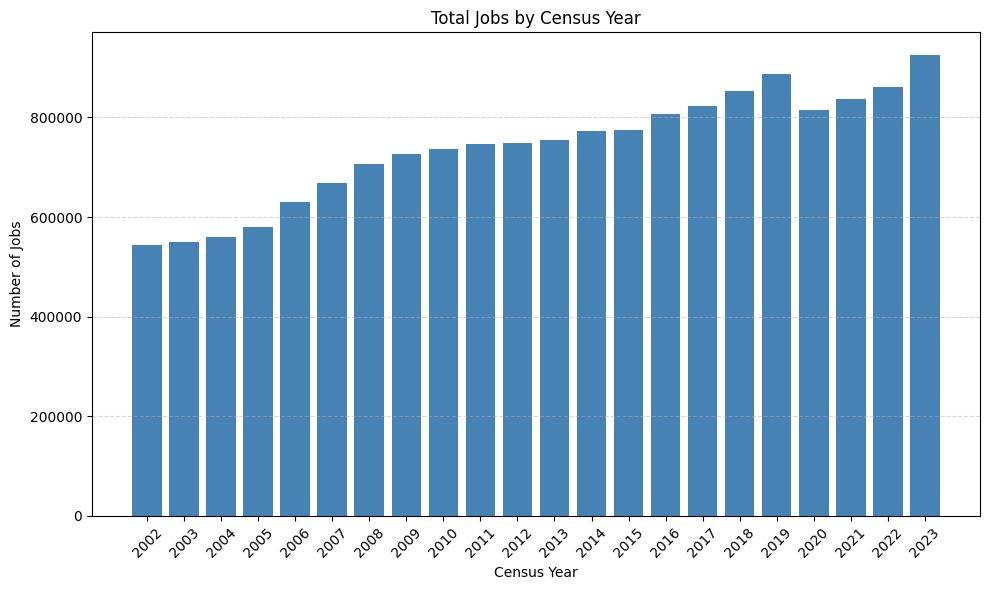

In [16]:
# Aggregate total number of jobs by census year
jobs_by_year = emp_block_df.groupby('census_year')['total_jobs_in_block'].sum().reset_index()

# Plot the total jobs by year
plt.figure(figsize=(10, 6))
plt.bar(jobs_by_year['census_year'].astype(str), jobs_by_year['total_jobs_in_block'], color='steelblue')
plt.title('Total Jobs by Census Year')
plt.xlabel('Census Year')
plt.ylabel('Number of Jobs')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Interpretation of Total Jobs by Census Year

The bar chart provides a summary of the total number of jobs recorded during each census year in the City of Melbourne. The overall trend indicates a steady increase in employment from 2002 to 2019, suggesting continuous economic and commercial development within the region.

A noticeable dip is observed in the years 2020 and 2021, likely reflecting the economic impact of the COVID-19 pandemic. However, this decline is followed by a strong recovery in 2022 and a peak in 2023, indicating a robust post-pandemic rebound in employment levels.

This pattern reflects both long-term urban growth and short-term disruptions caused by external global events.


### 2.1.2 Total Jobs by Industry Category – 2023

This section presents the distribution of total jobs across different industry sectors for the most recent census year (2023). It helps identify which sectors contributed the most to employment in Melbourne’s urban blocks during the latest recorded period.


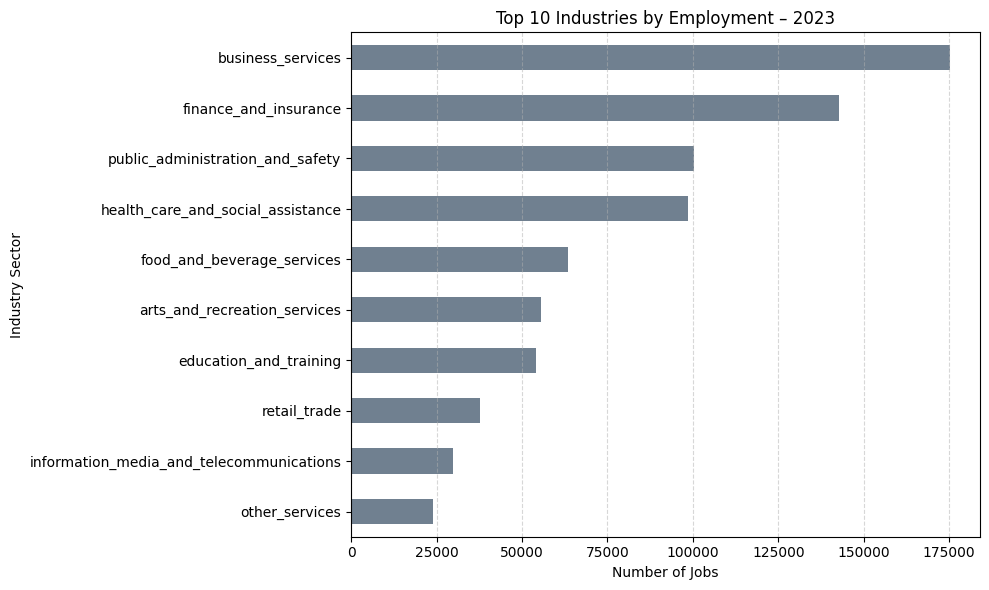

In [17]:
# Filter data for 2023
emp_2023 = emp_block_df[emp_block_df['census_year'] == 2023]

# Sum jobs for each industry column (excluding ID and total columns)
industry_2023_totals = emp_2023.iloc[:, 3:-1].sum().sort_values(ascending=False)

# Plot top 10 industries
plt.figure(figsize=(10, 6))
industry_2023_totals.head(10).plot(kind='barh', color='slategray')
plt.title('Top 10 Industries by Employment – 2023')
plt.xlabel('Number of Jobs')
plt.ylabel('Industry Sector')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Top Ten Industry Sectors by Employment in 2023

This horizontal bar chart presents the top ten industry sectors by employment for the year 2023. The following observations can be made:

- **Business services** emerges as the leading sector, employing around 175,000 individuals.  
- **Finance and insurance** and **public administration and safety** are also major employers, with each sector exceeding 100,000 jobs.  
- **Health care and social assistance** demonstrates strong representation, reflecting growing demand in this field.  
- Other significant contributors include **food and beverage services**, **education and training**, and **arts and recreation services**.

Overall, the results suggest that Melbourne's central areas are predominantly driven by service-oriented, professional, and governmental industries—characteristic of a knowledge-based urban economy.


### 2.1.3 Employment Distribution by CLUE Small Area – 2023

This section visualises the total number of jobs recorded in each CLUE Small Area for the most recent census year (2023). The analysis identifies specific regions within the City of Melbourne that have the highest employment concentration, highlighting key business and service hubs across the urban landscape.


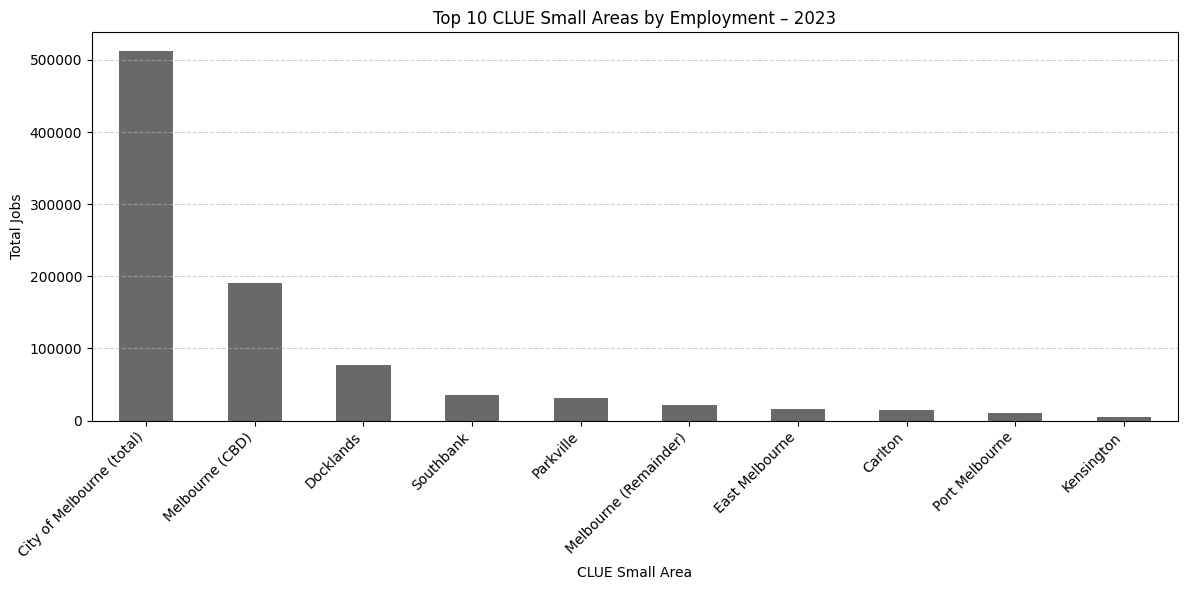

In [18]:
# Filter employment data for the latest year (2023)
latest_year = emp_block_df['census_year'].max()
latest_emp = emp_block_df[emp_block_df['census_year'] == latest_year]

# Group by CLUE Small Area and calculate total jobs
jobs_by_clue_area = latest_emp.groupby('clue_small_area')['total_jobs_in_block'].sum().sort_values(ascending=False)

# Plot the top 10 CLUE Small Areas by job count
plt.figure(figsize=(12, 6))
jobs_by_clue_area.head(10).plot(kind='bar', color='dimgray')
plt.title(f'Top 10 CLUE Small Areas by Employment – {latest_year}')
plt.xlabel('CLUE Small Area')
plt.ylabel('Total Jobs')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


#### Interpretation – Employment by CLUE Small Area (2023)

The bar chart illustrates the distribution of jobs across the top 10 CLUE Small Areas in the City of Melbourne for the year 2023. The majority of employment is concentrated within the **"City of Melbourne (Total)"** and **"Melbourne (CBD)"** areas, indicating their dominance as key economic zones. Specifically:

- **City of Melbourne (Total)** recorded the highest employment, exceeding 500,000 jobs.  
- **Melbourne (CBD)** alone accounted for approximately 190,000 jobs, reflecting its role as the central business and service hub.  
- Other significant contributors include **Docklands**, **Southbank**, and **Parkville**, each hosting a notable number of businesses and institutions.  
- Peripheral areas like **Kensington**, **Port Melbourne**, and **Carlton** contribute comparatively fewer jobs, yet still play important roles in supporting overall economic activity.

This spatial distribution highlights the centralisation of employment around core urban zones, offering a basis for identifying opportunities to balance economic growth across underutilised regions.


### 2.1.4 – Total Floor Space by CLUE Small Area (Latest Year)

This section analyses the distribution of total floor space across different CLUE Small Areas for the most recent census year.

The dataset is first filtered to include only the latest available year. The total floor space is then aggregated across all blocks within each CLUE Small Area. The objective is to identify the top 10 areas with the most built-up space, which can provide insight into where commercial, residential, or mixed-use development is most concentrated in the City of Melbourne.


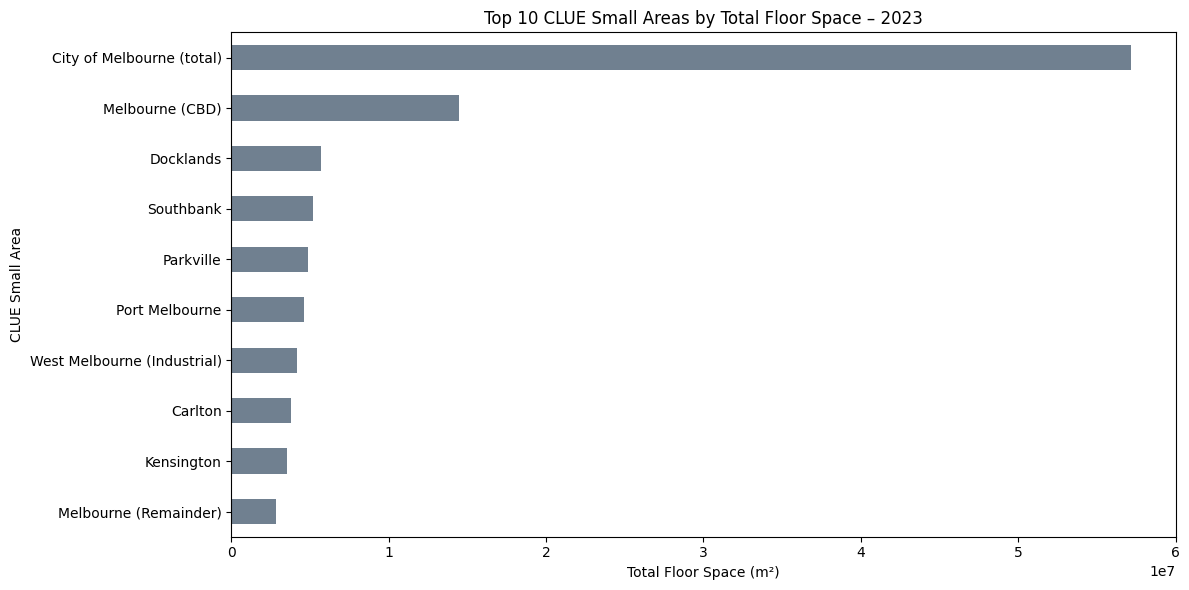

In [19]:
# Filter for the latest census year
latest_year = floor_df['census_year'].max()
latest_floor_data = floor_df[floor_df['census_year'] == latest_year]

# Group and sum floor space by CLUE Small Area
floor_by_area = latest_floor_data.groupby('clue_small_area')['total_floor_space_in_block'].sum().sort_values(ascending=False).head(10)

# Plot the result
plt.figure(figsize=(12, 6))
floor_by_area.sort_values().plot(kind='barh', color='slategray')
plt.title(f"Top 10 CLUE Small Areas by Total Floor Space – {latest_year}")
plt.xlabel("Total Floor Space (m²)")
plt.ylabel("CLUE Small Area")
plt.tight_layout()
plt.show()


### Interpretation – Total Floor Space by CLUE Small Area (2023)

The bar chart above shows the top 10 CLUE Small Areas ranked by total floor space in 2023. The **City of Melbourne (total)** aggregates all small areas and shows the highest floor space, which is expected as it includes the entirety of the municipality.

Focusing on individual areas, **Melbourne (CBD)** significantly leads among all localities, reflecting its dense commercial and high-rise development. Following the CBD, areas such as **Docklands**, **Southbank**, and **Parkville** also show substantial floor space allocation, which aligns with their known mix of commercial, residential, and institutional buildings.

This distribution helps to highlight the regions with the most built-up land, supporting planning decisions regarding infrastructure, zoning, and development priorities.



## 2.2 Exploratory Data Analysis – Floor Space Dataset

### 2.2.1 Year-wise Floor Space Distribution

This chart illustrates the total floor space recorded in Melbourne's CLUE blocks across census years. The objective is to examine how built-up space has expanded over time, reflecting trends in infrastructure development and urban growth.


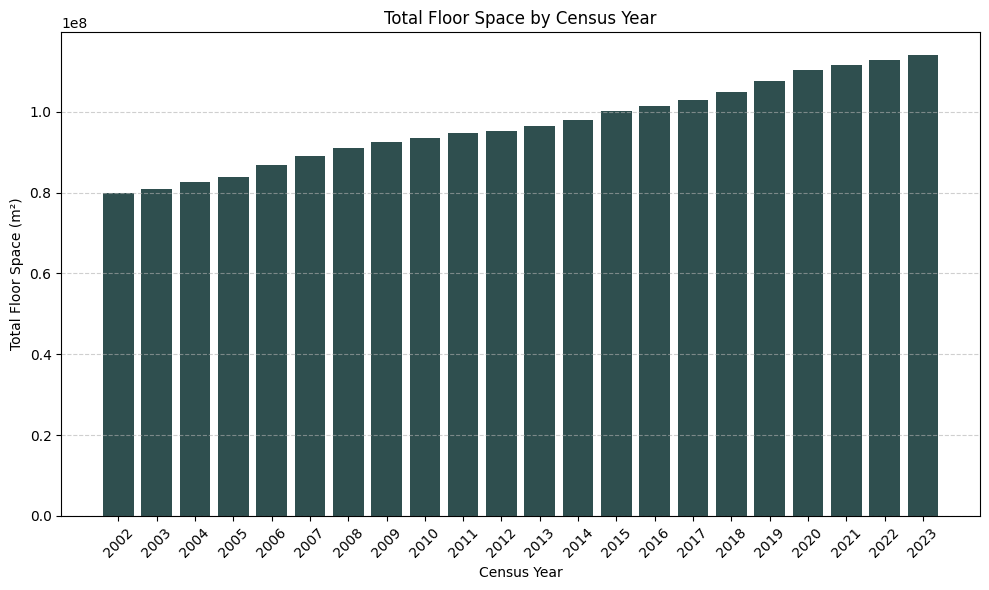

In [20]:
# Aggregate total floor space by census year
floor_yearly_total = floor_df.groupby('census_year')['total_floor_space_in_block'].sum().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(floor_yearly_total['census_year'].astype(str), 
        floor_yearly_total['total_floor_space_in_block'], 
        color='darkslategray')
plt.title('Total Floor Space by Census Year')
plt.xlabel('Census Year')
plt.ylabel('Total Floor Space (m²)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 2.2.1 Year-wise Floor Space Distribution – Interpretation

The bar chart illustrates the cumulative total floor space in Melbourne's CLUE blocks from 2002 to 2023. A clear upward trend is observed, signifying consistent urban development and expansion of infrastructure throughout the years. 

The total floor space increased from approximately 80 million square meters in 2002 to nearly 115 million square meters in 2023. This progressive growth reflects both new construction and redevelopment efforts aimed at accommodating the city's economic and population growth.


### 2.2.2 Use Type Breakdown of Floor Space – 2023

This section analyses the distribution of total floor space by use category for the most recent census year (2023). The floor space categories include commercial, residential, public infrastructure, and other urban functions.

By summing the space allocated to each use type, the chart reveals which functions occupy


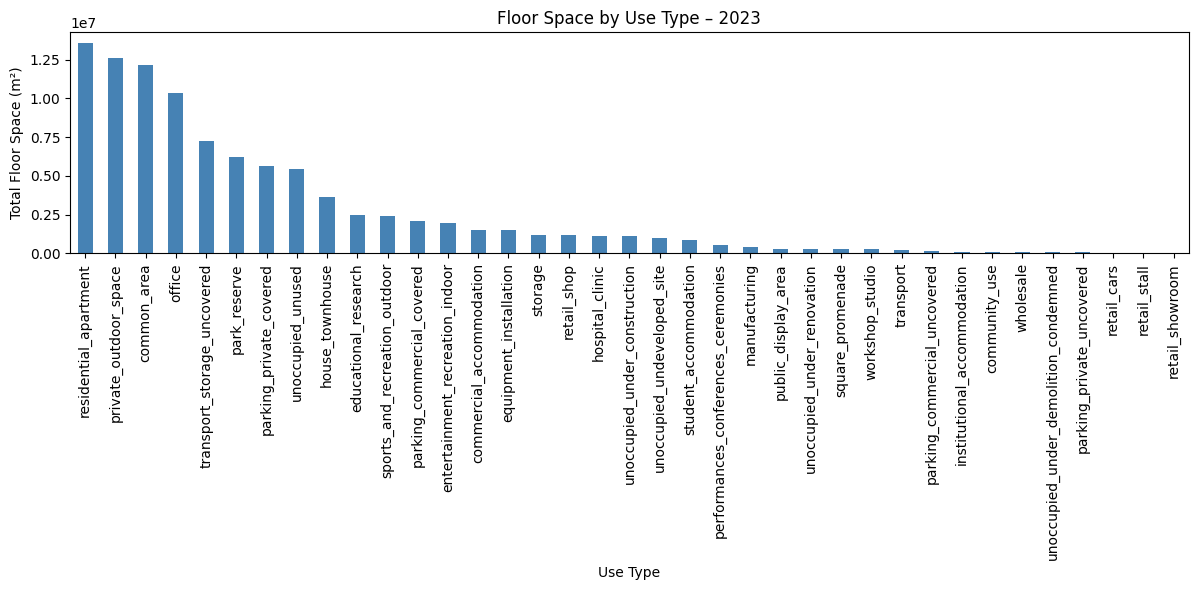

In [21]:
# Filter for 2023 data
floor_latest = floor_df[floor_df['census_year'] == 2023]

# Identify relevant use columns 
use_columns = floor_latest.columns[3:-1]  # Excludes census_year, block_id, clue_small_area, total

# Sum floor space by use type
use_totals = floor_latest[use_columns].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
use_totals.plot(kind='bar', color='steelblue')
plt.title('Floor Space by Use Type – 2023')
plt.xlabel('Use Type')
plt.ylabel('Total Floor Space (m²)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Interpretation

The chart presents the total floor space distribution by various use types within the City of Melbourne for the year 2023.

- **Residential apartments** dominate the city’s built environment, accounting for the largest portion of total floor space, followed closely by **private outdoor spaces** and **common areas**, reflecting dense urban living arrangements.
- **Office space** remains a major component, indicating strong demand for commercial infrastructure in central locations.
- Other significant contributors include **transport and storage**, **parks and reserves**, and various **parking facilities**, showing a balance between utility infrastructure and recreational land use.
- Categories such as **educational research**, **sports and recreation**, and **entertainment venues** occupy moderate amounts of space, highlighting Melbourne’s diverse functional landscape.
- A notable amount of space is still designated as **unoccupied or under construction**, pointing toward future urban development opportunities.

This breakdown provides insight into how urban floor space is allocated across functions and can guide decisions related to zoning, investment, and infrastructure development.


### 2.2.3 Floor Space Trends in Selected Areas (2002–2023)

This section presents the trend of total floor space development over time across key CLUE Small Areas: Melbourne (CBD), Docklands, Southbank, Parkville, and a combined category for all remaining areas titled "Other."

Analysing these trends helps identify which parts of the city have experienced significant infrastructure growth over the years. This insight is useful for urban planning, infrastructure investment, and understanding area-level development dynamics.


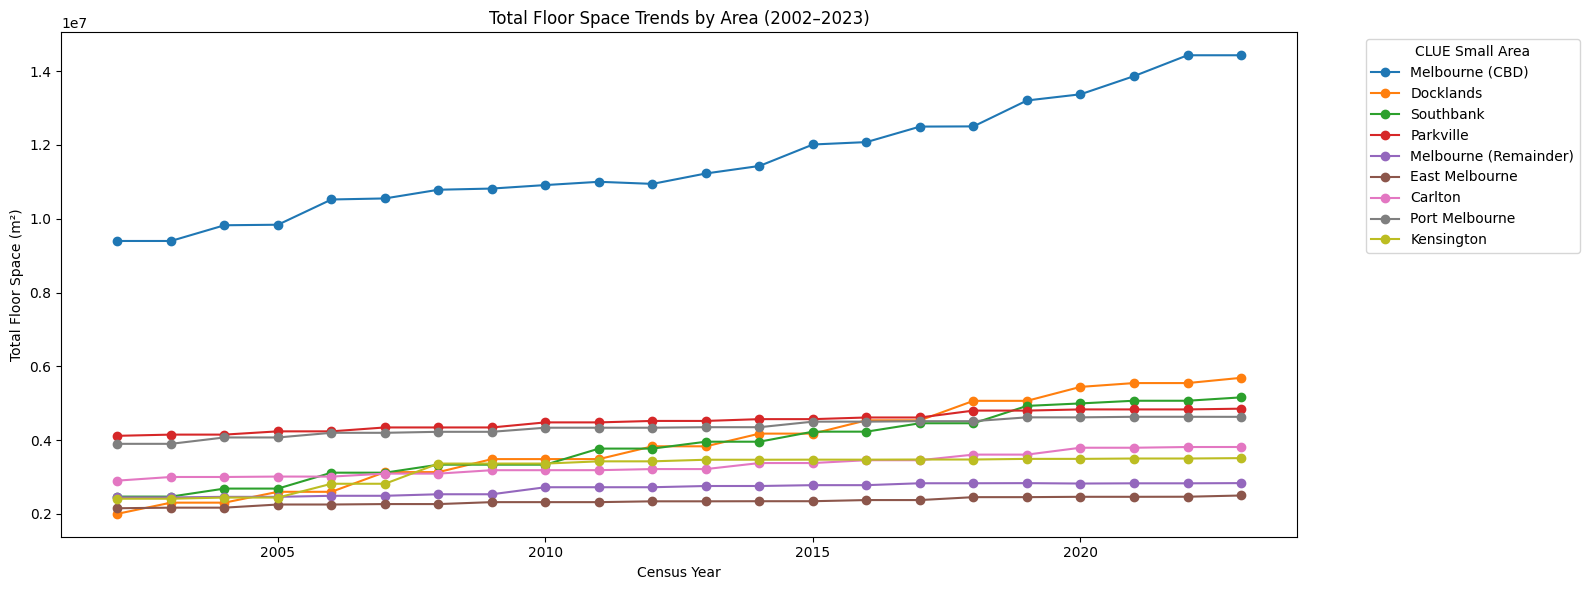

In [22]:
selected_areas = [
    "Melbourne (CBD)",
    "Docklands",
    "Southbank",
    "Parkville",
    "Melbourne (Remainder)",
    "East Melbourne",
    "Carlton",
    "Port Melbourne",
    "Kensington"
]

# Filter the floor space dataframe for selected areas
filtered_df = floor_df[floor_df["clue_small_area"].isin(selected_areas)]

# Pivot the data to get floor space over years per area
pivot_table = filtered_df.pivot_table(
    index='census_year',
    columns='clue_small_area',
    values='total_floor_space_in_block',  
    aggfunc='sum'
)

# Plotting
plt.figure(figsize=(16, 6))
for area in selected_areas:
    if area in pivot_table.columns:
        plt.plot(pivot_table.index, pivot_table[area], marker='o', label=area)

plt.title("Total Floor Space Trends by Area (2002–2023)")
plt.xlabel("Census Year")
plt.ylabel("Total Floor Space (m²)")
plt.legend(title="CLUE Small Area", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Interpretation:

The line graph illustrates the yearly increase in total floor space for each selected CLUE small area. 

- **Melbourne (CBD)** shows a consistent and substantial rise, indicating ongoing urban expansion.
-  **Docklands** exhibit significant upward trends, highlighting them as primary zones of commercial and residential development.
- Other areas such as **Southbank**, **Parkville**, and **Carlton** also reflect gradual but steady growth over the years.
- This trend data provides critical insights into where planning efforts, infrastructure investment, and service demand are likely to be concentrated.


### 2.3 Public Transport Dataset: Spatial Distribution and Availability

This section explores the spatial distribution of Melbourne's public transport infrastructure, focusing on bus stops and City Circle tram stops within the City of Melbourne. The goal is to analyse how public transport access aligns with employment hubs and floor space clusters identified earlier. This includes examining the number of stops in each CLUE small area and visualising their geographic placement on a city map.


### Step 1 – Load and Preview Bus and Tram Stop Datasets

This step loads the cleaned datasets for Melbourne’s bus stops and City Circle tram stops. It previews the first few records of each to verify structure and key columns required for later grouping, particularly `clue_area` or spatial fields.


In [23]:
# Preview first few rows of Bus Stops dataset
print(" Bus Stops Dataset – First 5 Records")
display(Bus_df.head())

# Check shape and columns
print("\nShape:", Bus_df.shape)
print("\nColumns:", Bus_df.columns.tolist())

# Preview first few rows of Tram Stops dataset
print("\n Tram Stops Dataset – First 5 Records")
display(tram_df.head())

# Check shape and columns
print("\nShape:", tram_df.shape)
print("\nColumns:", tram_df.columns.tolist())




 Bus Stops Dataset – First 5 Records


geo_point_2d  \
0   -37.81842481335676, 144.96889648633675   
1   -37.81767597164006, 144.95888238475013   
2   -37.78188915501449, 144.95963193312105   
3  -37.793726533289785, 144.94716743007305   
4   -37.80286165064241, 144.92778487963457   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.96889648633675, -37.81842...   573333   29.149053   
1  {"coordinates": [144.95888238475013, -37.81767...        0   10.537902   
2  {"coordinates": [144.95963193312105, -37.78188...        0   25.269643   
3  {"coordinates": [144.94716743007305, -37.79372...        0   44.230506   
4  {"coordinates": [144.92778487963457, -37.80286...        0   67.718553   

   addressp_1 asset_clas               asset_type  objectid   str_id  \
0         288    Signage  Sign - Public Transport       749  1249454   
1         105    Signage  Sign - Public Transport      2098  1247042   
2         212    Signage  Sign - Public Transport      2143  1252383   
3         237    Signage  Sign - Public Transport      2627  1249788   
4         360    Signage  Sign - Public Transport      3306  1235311   

   addresspt  asset_subt                       model_desc   mcc_id  \
0     606816         NaN  Sign - Public Transport 1 Panel  1249454   
1     507646         NaN  Sign - Public Transport 1 Panel  1247042   
2     108510         NaN  Sign - Public Transport 1 Panel  1252383   
3     100087         NaN  Sign - Public Transport 1 Panel  1249788   
4     103002         NaN  Sign - Public Transport 1 Panel  1235311   

   roadseg_id                                        descriptio model_no  \
0           0  Sign - Public Transport 1 Panel Bus Stop Type 12     P.16   
1       20118   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
2       22387   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
3       20919   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16   
4       21680  Sign - Public Transport 1 Panel Bus Stop Type 13     P.16   

    latitude   longitude  
0 -37.818425  144.968896  
1 -37.817676  144.958882  
2 -37.781889  144.959632  
3 -37.793727  144.947167  
4 -37.802862  144.927785


Shape: (309, 18)

Columns: ['geo_point_2d', 'geo_shape', 'prop_id', 'addresspt1', 'addressp_1', 'asset_clas', 'asset_type', 'objectid', 'str_id', 'addresspt', 'asset_subt', 'model_desc', 'mcc_id', 'roadseg_id', 'descriptio', 'model_no', 'latitude', 'longitude']

 Tram Stops Dataset – First 5 Records


geo_point_2d  \
0   -37.82023778673241, 144.95786314283018   
1   -37.82097269970027, 144.95546153614245   
2   -37.82190465062153, 144.95109855638137   
3  -37.811771476718356, 144.95644059700524   
4   -37.81105928060848, 144.95891745116262   

                                           geo_shape  \
0  {"coordinates": [144.95786314283018, -37.82023...   
1  {"coordinates": [144.95546153614245, -37.82097...   
2  {"coordinates": [144.95109855638137, -37.82190...   
3  {"coordinates": [144.95644059700524, -37.81177...   
4  {"coordinates": [144.95891745116262, -37.81105...   

                                   name      xorg stop_no  xsource  \
0  Melbourne Aquarium / Flinders Street  GIS Team       2  Mapbase   
1      Spencer Street / Flinders Street  GIS Team       1  Mapbase   
2       The Goods Shed / Wurundjeri Way  GIS Team      D5  Mapbase   
3      William Street / La Trobe Street  GIS Team       3  Mapbase   
4        Queen Street / La Trobe Street  GIS Team       4  Mapbase   

        xdate  mccid_int   latitude   longitude  
0  2011-10-18          4 -37.820238  144.957863  
1  2011-10-18          5 -37.820973  144.955462  
2  2011-10-18          7 -37.821905  144.951099  
3  2011-10-18         16 -37.811771  144.956441  
4  2011-10-18         17 -37.811059  144.958917


Shape: (28, 10)

Columns: ['geo_point_2d', 'geo_shape', 'name', 'xorg', 'stop_no', 'xsource', 'xdate', 'mccid_int', 'latitude', 'longitude']


### Step 2 – Convert Bus and Tram DataFrames to GeoDataFrames

Before conducting spatial analysis, the bus and tram datasets must be converted into GeoDataFrames using their latitude and longitude. This will enable accurate spatial joins with the CLUE block dataset to determine which area each stop falls into.


In [24]:
# Import required libraries
#import geopandas as gpd
#from shapely.geometry import Point

# Clean and convert Bus Stop data to GeoDataFrame
# Drop rows with missing coordinate data
bus_df = Bus_df.dropna(subset=['geo_point_2d'])

# Split 'geo_point_2d' into separate latitude and longitude columns
bus_df[['latitude', 'longitude']] = bus_df['geo_point_2d'].str.split(',', expand=True).astype(float)

# Create GeoDataFrame from bus stop coordinates
bus_gdf = gpd.GeoDataFrame(
    bus_df,
    geometry=gpd.points_from_xy(bus_df['longitude'], bus_df['latitude']),
    crs="EPSG:4326"
)

# Clean and convert Tram Stop data to GeoDataFrame
# Drop rows with missing coordinate data
tram_df = tram_df.dropna(subset=['geo_point_2d'])

# Split 'geo_point_2d' into separate latitude and longitude columns
tram_df[['latitude', 'longitude']] = tram_df['geo_point_2d'].str.split(',', expand=True).astype(float)

# Create GeoDataFrame from tram stop coordinates
tram_gdf = gpd.GeoDataFrame(
    tram_df,
    geometry=gpd.points_from_xy(tram_df['longitude'], tram_df['latitude']),
    crs="EPSG:4326"
)

# Step 4: Print summary
print("Bus GeoDataFrame created:", bus_gdf.shape)
print("Tram GeoDataFrame created:", tram_gdf.shape)


Bus GeoDataFrame created: (309, 19)
Tram GeoDataFrame created: (28, 11)



### Step 3 Number of Stops per CLUE Small Area

This step calculates the number of public transport stops—both bus and tram—within each CLUE Small Area. By performing a spatial join between the transport stop locations and the CLUE block polygons, each stop is assigned to a corresponding CLUE area. The final result is a summary count of how many bus and tram stops exist in each area, providing insight into the distribution of transport infrastructure across the city.


In [25]:
# Perform spatial joins to map stops to CLUE areas
# This joins the stops to the polygons in the block dataset
bus_joined = gpd.sjoin(bus_gdf, block_gdf, how="inner", predicate='within')
tram_joined = gpd.sjoin(tram_gdf, block_gdf, how="inner", predicate='within')

# Group by CLUE Small Area and count stops
bus_stop_counts = bus_joined.groupby('clue_area').size().reset_index(name='bus_stop_count')
tram_stop_counts = tram_joined.groupby('clue_area').size().reset_index(name='tram_stop_count')

# Merge the two stop counts into a single dataframe for comparison
combined_stop_counts = pd.merge(bus_stop_counts, tram_stop_counts, on='clue_area', how='outer').fillna(0)

# Convert counts to integers 
combined_stop_counts['bus_stop_count'] = combined_stop_counts['bus_stop_count'].astype(int)
combined_stop_counts['tram_stop_count'] = combined_stop_counts['tram_stop_count'].astype(int)

# Display result
print("Combined stop counts by CLUE Small Area:")
display(combined_stop_counts.sort_values(by='bus_stop_count', ascending=False))


Combined stop counts by CLUE Small Area:


clue_area  bus_stop_count  tram_stop_count
4                Melbourne (CBD)              54               17
0                        Carlton              48                0
6                North Melbourne              39                0
10                     Southbank              29                0
7                      Parkville              27                0
8                 Port Melbourne              22                0
5          Melbourne (Remainder)              19                0
3                     Kensington              18                0
11   West Melbourne (Industrial)              18                0
12  West Melbourne (Residential)              13                0
9                    South Yarra              12                0
1                      Docklands               9                8
2                 East Melbourne               1                3

### Step 4 – Visualising Stop Counts with a Horizontal Bar Chart

This step presents the distribution of public transport stops across CLUE small areas using a horizontal stacked bar chart. By displaying the number of bus and tram stops side by side, it allows for an intuitive comparison of accessibility within each area. This visualisation supports identification of areas with high or limited transport coverage, aiding urban planning and infrastructure development decisions.


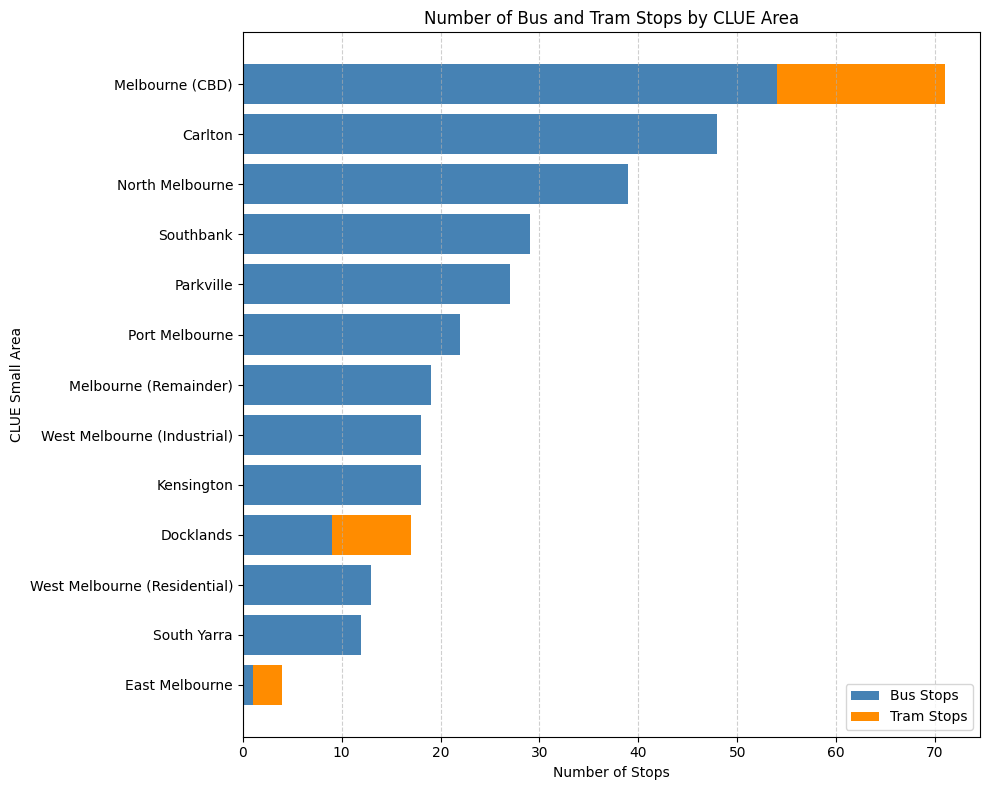

In [26]:
#import matplotlib.pyplot as plt

# Sort by total stops for clearer comparison
combined_stop_counts['total_stops'] = combined_stop_counts['bus_stop_count'] + combined_stop_counts['tram_stop_count']
sorted_counts = combined_stop_counts.sort_values(by='total_stops', ascending=True)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_counts['clue_area'], sorted_counts['bus_stop_count'], label='Bus Stops', color='steelblue')
plt.barh(sorted_counts['clue_area'], sorted_counts['tram_stop_count'], 
         left=sorted_counts['bus_stop_count'], label='Tram Stops', color='darkorange')

plt.xlabel("Number of Stops")
plt.ylabel("CLUE Small Area")
plt.title("Number of Bus and Tram Stops by CLUE Area")
plt.legend()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


### Interpretation of Transport Stop Distribution

The bar chart above displays the number of bus and tram stops within various CLUE small areas in Melbourne. Melbourne (CBD) leads significantly in overall public transport infrastructure, with a balanced distribution of both bus and tram stops. Carlton and North Melbourne follow, though they are predominantly served by bus stops.

Areas such as Docklands and East Melbourne exhibit a notable share of tram stops, while others like Parkville and Southbank have fewer overall stops despite being active zones. This analysis highlights disparities in transport coverage, suggesting potential areas for infrastructure development, particularly in regions with lower total stop counts or lacking multimodal options.


### Markdown Explanation of Findings

The horizontal bar chart visualises the combined number of bus and tram stops across various CLUE small areas within Melbourne. The results indicate that **Melbourne (CBD)** has the highest overall count, with a significant contribution from both bus and tram stops, highlighting its role as a central transport hub. **Carlton**, **North Melbourne**, and **Southbank** also show strong bus infrastructure but minimal tram presence. In contrast, **Docklands** has a more balanced distribution between bus and tram services.

These findings reflect how public transport is spatially concentrated in central and business-heavy locations, supporting commuter flow and urban accessibility. Areas with lower counts, such as **East Melbourne** or **South Yarra**, may be targeted for potential transport service expansion to balance accessibility.


### Step 5 – Visual Representation of Public Transport Stops

This step provides a geospatial map showing the distribution of public transport stops—bus and tram—across the City of Melbourne. Visualising these locations helps identify clusters, gaps, and accessibility coverage, which is essential for urban planning and transport strategy development.


In [ ]:
#import folium
#from folium.plugins import MarkerCluster

# Initialise map centered on Melbourne
melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13, tiles='cartodbpositron')

# Add Bus Stops
bus_cluster = MarkerCluster(name="Bus Stops").add_to(melbourne_map)
for idx, row in bus_gdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"<b>Bus Stop</b><br>ID: {row.get('prop_id', 'N/A')}<br>Street: {row.get('addresspt', 'N/A')}", max_width=250),
        tooltip="Bus Stop",
        icon=folium.Icon(color='blue', icon='bus', prefix='fa')
    ).add_to(bus_cluster)

# Add Tram Stops
tram_cluster = MarkerCluster(name="Tram Stops").add_to(melbourne_map)
for idx, row in tram_gdf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(f"<b>Tram Stop</b><br>Name: {row.get('name', 'N/A')}<br>Stop No: {row.get('stop_no', 'N/A')}", max_width=250),
        tooltip="Tram Stop",
        icon=folium.Icon(color='green', icon='train', prefix='fa')
    ).add_to(tram_cluster)

# Add Layer Control
folium.LayerControl(collapsed=False).add_to(melbourne_map)

# Display map
melbourne_map



 # Section 3: Spatial Accessibility Analysis

### 3.1  Spatial Join with Block Dataset

This section aims to enhance the analysis of transport accessibility by spatially linking transport infrastructure data (bus and tram stops) with employment and floor space data at the block level. By performing spatial joins using the CLUE block geometries, this step enables calculation of metrics such as the number of stops per block, worker-to-seat ratios, and worker-to-floor-space ratios. These metrics provide deeper insight into how well different areas are supported by public transport relative to their job density and built environment.


### Step 1 – Ensure Consistent Coordinate Reference System (CRS)

Before performing any spatial operations such as joins, it is essential to verify that all involved GeoDataFrames share the same Coordinate Reference System (CRS). In this project, the datasets include `bus_gdf`, `tram_gdf`, `emp_block_df` , `floor_df` , and `block_gdf`. Inconsistencies in CRS can lead to incorrect spatial alignment and inaccurate results.

This step involves checking the CRS of each GeoDataFrame and reprojecting them if necessary to a common standard, such as EPSG:4326 (WGS84), which is commonly used for mapping coordinates with latitude and longitude.


In [28]:
# Step 1: Check CRS of each GeoDataFrame
print("CRS of Bus Stops:", bus_gdf.crs)
print("CRS of Tram Stops:", tram_gdf.crs)
print("CRS of Block Geometry:", block_gdf.crs)


# Step 2: Set or convert to common CRS (EPSG:4326 - WGS84)
target_crs = "EPSG:4326"

# Reproject all to the same CRS
bus_gdf = bus_gdf.to_crs(target_crs)
tram_gdf = tram_gdf.to_crs(target_crs)
block_gdf = block_gdf.to_crs(target_crs)


CRS of Bus Stops: EPSG:4326
CRS of Tram Stops: EPSG:4326
CRS of Block Geometry: EPSG:4326


###  Step 2 – Spatially Join Stops with Block Polygons

This step performs spatial joins to assign each bus and tram stop to a specific block by checking whether it falls within the polygon boundaries defined in the `block_gdf`. This allows aligning public transport data with employment and floor space datasets, which are also organised by `block_id`.


In [29]:


# Remove 'index_right' 
for df in [bus_gdf, tram_gdf, block_gdf]:
    if 'index_right' in df.columns:
        df.drop(columns=['index_right'], inplace=True)

# Perform spatial join to assign each stop to a block polygon
bus_with_blocks = gpd.sjoin(bus_gdf, block_gdf[['geometry', 'block_id']], how='inner', predicate='within')
tram_with_blocks = gpd.sjoin(tram_gdf, block_gdf[['geometry', 'block_id']], how='inner', predicate='within')

# Print result summaries
print("Number of Bus Stops assigned to blocks:", bus_with_blocks.shape[0])
print("Number of Tram Stops assigned to blocks:", tram_with_blocks.shape[0])

# Preview the first 5 rows of each joined dataset
print("\nPreview  Bus Stops with Block Assignment:")
display(bus_with_blocks.head())

print("\nPreview Tram Stops with Block Assignment:")
display(tram_with_blocks.head())


Number of Bus Stops assigned to blocks: 309
Number of Tram Stops assigned to blocks: 28

Preview  Bus Stops with Block Assignment:


geo_point_2d  \
0   -37.81842481335676, 144.96889648633675   
1   -37.81767597164006, 144.95888238475013   
2   -37.78188915501449, 144.95963193312105   
3  -37.793726533289785, 144.94716743007305   
4   -37.80286165064241, 144.92778487963457   

                                           geo_shape  prop_id  addresspt1  \
0  {"coordinates": [144.96889648633675, -37.81842...   573333   29.149053   
1  {"coordinates": [144.95888238475013, -37.81767...        0   10.537902   
2  {"coordinates": [144.95963193312105, -37.78188...        0   25.269643   
3  {"coordinates": [144.94716743007305, -37.79372...        0   44.230506   
4  {"coordinates": [144.92778487963457, -37.80286...        0   67.718553   

   addressp_1 asset_clas               asset_type  objectid   str_id  \
0         288    Signage  Sign - Public Transport       749  1249454   
1         105    Signage  Sign - Public Transport      2098  1247042   
2         212    Signage  Sign - Public Transport      2143  1252383   
3         237    Signage  Sign - Public Transport      2627  1249788   
4         360    Signage  Sign - Public Transport      3306  1235311   

   addresspt  ...                       model_desc   mcc_id  roadseg_id  \
0     606816  ...  Sign - Public Transport 1 Panel  1249454           0   
1     507646  ...  Sign - Public Transport 1 Panel  1247042       20118   
2     108510  ...  Sign - Public Transport 1 Panel  1252383       22387   
3     100087  ...  Sign - Public Transport 1 Panel  1249788       20919   
4     103002  ...  Sign - Public Transport 1 Panel  1235311       21680   

                                         descriptio model_no   latitude  \
0  Sign - Public Transport 1 Panel Bus Stop Type 12     P.16 -37.818425   
1   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16 -37.817676   
2   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16 -37.781889   
3   Sign - Public Transport 1 Panel Bus Stop Type 8     P.16 -37.793727   
4  Sign - Public Transport 1 Panel Bus Stop Type 13     P.16 -37.802862   

    longitude                     geometry index_right  block_id  
0  144.968896   POINT (144.9689 -37.81842)         197         6  
1  144.958882  POINT (144.95888 -37.81768)         103        32  
2  144.959632  POINT (144.95963 -37.78189)         473       904  
3  144.947167  POINT (144.94717 -37.79373)           7       303  
4  144.927785  POINT (144.92778 -37.80286)         398       502  

[5 rows x 21 columns]


Preview Tram Stops with Block Assignment:


geo_point_2d  \
0   -37.82023778673241, 144.95786314283018   
1   -37.82097269970027, 144.95546153614245   
2   -37.82190465062153, 144.95109855638137   
3  -37.811771476718356, 144.95644059700524   
4   -37.81105928060848, 144.95891745116262   

                                           geo_shape  \
0  {"coordinates": [144.95786314283018, -37.82023...   
1  {"coordinates": [144.95546153614245, -37.82097...   
2  {"coordinates": [144.95109855638137, -37.82190...   
3  {"coordinates": [144.95644059700524, -37.81177...   
4  {"coordinates": [144.95891745116262, -37.81105...   

                                   name      xorg stop_no  xsource  \
0  Melbourne Aquarium / Flinders Street  GIS Team       2  Mapbase   
1      Spencer Street / Flinders Street  GIS Team       1  Mapbase   
2       The Goods Shed / Wurundjeri Way  GIS Team      D5  Mapbase   
3      William Street / La Trobe Street  GIS Team       3  Mapbase   
4        Queen Street / La Trobe Street  GIS Team       4  Mapbase   

        xdate  mccid_int   latitude   longitude                     geometry  \
0  2011-10-18          4 -37.820238  144.957863  POINT (144.95786 -37.82024)   
1  2011-10-18          5 -37.820973  144.955462  POINT (144.95546 -37.82097)   
2  2011-10-18          7 -37.821905  144.951099    POINT (144.9511 -37.8219)   
3  2011-10-18         16 -37.811771  144.956441  POINT (144.95644 -37.81177)   
4  2011-10-18         17 -37.811059  144.958917  POINT (144.95892 -37.81106)   

   index_right  block_id  
0          545        12  
1          105        11  
2           37      1105  
3          537        83  
4          338        84

### Step 3 – Aggregate Number of Stops per Block

This step focuses on quantifying public transport infrastructure by counting how many bus and tram stops are present within each block (as identified by `block_id`). The spatial join from the previous step provides a one-to-one mapping between individual stops and blocks. Aggregating this information allows for comparative analysis of accessibility across the city. The final output will be two separate dataframes: one for bus stop counts and one for tram stop counts, grouped by `block_id`.


In [30]:


# Count bus stops per block
bus_counts_per_block = bus_with_blocks.groupby('block_id').size().reset_index(name='bus_stop_count')

# Count tram stops per block
tram_counts_per_block = tram_with_blocks.groupby('block_id').size().reset_index(name='tram_stop_count')

# Preview results
print("Bus Stops per Block:")
display(bus_counts_per_block.head())

print("\nTram Stops per Block:")
display(tram_counts_per_block.head())


Bus Stops per Block:


block_id  bus_stop_count
0         2               3
1         4               2
2         6               1
3        13               2
4        22               2


Tram Stops per Block:


block_id  tram_stop_count
0         4                3
1         6                2
2        11                1
3        12                1
4        18                1

In [31]:
# Group by block_id and count stops
bus_block_counts = bus_with_blocks.groupby('block_id').size().reset_index(name='bus_stop_count')
tram_block_counts = tram_with_blocks.groupby('block_id').size().reset_index(name='tram_stop_count')

# Merge counts into a combined dataframe
combined_block_counts = pd.merge(bus_block_counts, tram_block_counts, on='block_id', how='outer').fillna(0)

# Convert stop counts to integers
combined_block_counts['bus_stop_count'] = combined_block_counts['bus_stop_count'].astype(int)
combined_block_counts['tram_stop_count'] = combined_block_counts['tram_stop_count'].astype(int)

# Display the result sorted by total stops
combined_block_counts['total_stops'] = combined_block_counts['bus_stop_count'] + combined_block_counts['tram_stop_count']
combined_block_counts = combined_block_counts.sort_values(by='total_stops', ascending=False)

# Display table
print("Combined stop counts by Block ID:")
display(combined_block_counts.head(15))  # Show top 15 blocks by stop count


Combined stop counts by Block ID:


block_id  bus_stop_count  tram_stop_count  total_stops
162       852               7                0            7
186       931               6                0            6
67        270               5                0            5
190      1006               5                0            5
112       502               5                0            5
1           4               2                3            5
147       783               4                0            4
20         71               4                0            4
12         33               4                0            4
149       785               4                0            4
145       781               4                0            4
8          23               4                0            4
24         83               3                1            4
25         84               2                2            4
53        233               3                0            3

### Step 4 – Merge with Employment and Floor Space Datasets

This step involves merging the combined stop counts by `block_id` with employment and floor space datasets that are also indexed by `block_id`. The purpose of this merge is to enable comparative spatial analysis between transport availability (bus/tram stops) and key urban features such as job concentration and commercial floor space.

Once merged, this integrated dataset will support the calculation of ratios such as:
- Number of jobs per stop (worker-to-stop ratio)
- Floor space per stop (space-to-stop ratio)

These ratios help identify areas of imbalance where public transport may be over- or under-supplied relative to demand.


In [32]:


# Prepare the employment dataset (latest year only)
latest_year = emp_block_df['census_year'].max()
emp_latest = emp_block_df[emp_block_df['census_year'] == latest_year][['block_id', 'total_jobs_in_block']]

# Prepare the floor space dataset (latest year only)
floor_latest = floor_df[floor_df['census_year'] == latest_year][['block_id', 'total_floor_space_in_block']]

# Merge all datasets by block_id
merged_df = combined_block_counts.merge(emp_latest, on='block_id', how='left')
merged_df = merged_df.merge(floor_latest, on='block_id', how='left')

# Fill any remaining NaNs with 0
merged_df.fillna(0, inplace=True)

# Preview the merged result
print("Merged Dataset Sample:")
display(merged_df.head())


Merged Dataset Sample:


block_id  bus_stop_count  tram_stop_count  total_stops  \
0       852               7                0            7   
1       931               6                0            6   
2       270               5                0            5   
3      1006               5                0            5   
4       502               5                0            5   

   total_jobs_in_block  total_floor_space_in_block  
0                244.0                   1002694.0  
1               7977.0                   2130081.0  
2               5992.0                    609247.0  
3                294.0                    962708.0  
4                676.0                    312865.0

### Step 5 – Visualise Spatial Coverage of Public Transport Stops

In this step, a choropleth map is created to visually represent the distribution of total transport stops across different city blocks. Each block is coloured based on the total number of bus and tram stops within its boundary. This helps highlight areas that are well-served by public transport and those with relatively limited accessibility.

Such spatial visualisation aids planners and analysts in identifying infrastructure gaps and prioritising areas for transport improvements.


In [ ]:
#import folium
#from folium import Choropleth
#import json

# Visualise total stop count per block using choropleth

# Merge block geometry with transport stop counts
block_map_data = block_gdf.merge(combined_block_counts, on='block_id', how='left').fillna(0)

# Convert to GeoJSON for folium
block_geojson = block_map_data.to_crs(epsg=4326).to_json()

# Initialise map
choropleth_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13, tiles='cartodbpositron')

# Add choropleth layer
Choropleth(
    geo_data=block_geojson,
    name='Total Transport Stops',
    data=block_map_data,
    columns=['block_id', 'total_stops'],
    key_on='feature.properties.block_id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Total Transport Stops per Block'
).add_to(choropleth_map)

# Optional: Add popups for selected blocks
for _, row in block_map_data.iterrows():
    folium.Popup(f"Block ID: {row['block_id']}<br>Total Stops: {int(row['total_stops'])}")\
        .add_to(folium.GeoJson(row['geometry'], name="popup"))

# Add layer control
folium.LayerControl().add_to(choropleth_map)

# Display the map
choropleth_map


In [34]:
#import folium
#from folium.features import GeoJson, GeoJsonTooltip

# Merge stop counts with clue_area info from block_gdf
block_map_data = block_gdf[['block_id', 'clue_area', 'geometry']].merge(combined_block_counts, on='block_id', how='left').fillna(0)

# Reproject to WGS84
block_map_data = block_map_data.to_crs(epsg=4326)

# Create folium map centered on Melbourne
melbourne_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=13, tiles='cartodbpositron')

# layer with tooltip
geojson = GeoJson(
    block_map_data,
    name="Public Transport Stops by Block",
    tooltip=GeoJsonTooltip(
        fields=["clue_area", "bus_stop_count", "tram_stop_count", "total_stops"],
        aliases=["CLUE Area:", "Bus Stops:", "Tram Stops:", "Total Stops:"],
        localize=True,
        sticky=False,
        labels=True,
        style=(
            "background-color: white; color: #333333; font-family: Arial; "
            "font-size: 12px; padding: 5px;"
        )
    ),
    style_function=lambda feature: {
        'fillColor': '#4682B4',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.6
    },
    highlight_function=lambda x: {'weight': 2, 'fillOpacity': 0.9}
)

geojson.add_to(melbourne_map)
folium.LayerControl().add_to(melbourne_map)

# Show the map
melbourne_map


### 3.2  Calculating Accessibility Metrics
### Step 01: Coordinate Reference System (CRS) Validation

This step ensures that all spatial datasets (bus stops, tram stops, block boundaries) use the same coordinate reference system. CRS consistency is critical for accurate spatial operations such as joins and overlays.


In [35]:
# Check and align CRS
print(bus_gdf.crs)
print(tram_gdf.crs)
print(block_gdf.crs)

# Convert if needed (already all EPSG:4326 in this case)
bus_gdf = bus_gdf.to_crs(epsg=4326)
tram_gdf = tram_gdf.to_crs(epsg=4326)
block_gdf = block_gdf.to_crs(epsg=4326)


EPSG:4326
EPSG:4326
EPSG:4326


### Step 02 – Calculating Accessibility Metrics
This step aims to assess the balance between public transport infrastructure and urban demand indicators such as employment and built area. Two key ratios are computed:

- **Transport-to-Worker Ratio**:  
  This is calculated as the total number of stops (bus + tram) divided by the number of jobs in each block. It provides insight into whether transport supply matches employment density.

- **Transport-to-Floor Space Ratio**:  
  This is calculated as the total number of stops divided by the total commercial floor space in the block. It indicates how well built infrastructure is supported by transport availability.

These ratios will help highlight areas that are over- or under-served by public transport in relation to job availability and commercial activity.


In [36]:


# Avoid division by zero by replacing 0 with NaN temporarily
merged_df['safe_jobs'] = merged_df['total_jobs_in_block'].replace(0, np.nan)
merged_df['safe_space'] = merged_df['total_floor_space_in_block'].replace(0, np.nan)

# Calculate Ratios
merged_df['transport_to_worker_ratio'] = merged_df['total_stops'] / merged_df['safe_jobs']
merged_df['transport_to_space_ratio'] = merged_df['total_stops'] / merged_df['safe_space']

# Replace NaN back with 0 where appropriate
merged_df[['transport_to_worker_ratio', 'transport_to_space_ratio']] = merged_df[
    ['transport_to_worker_ratio', 'transport_to_space_ratio']
].fillna(0)

# Preview top 10 blocks sorted by transport-to-worker ratio
print("Top blocks by transport-to-worker ratio:")
display(merged_df.sort_values(by='transport_to_worker_ratio', ascending=False).head(10))

# Preview top 10 blocks sorted by transport-to-floor space ratio
print("Top blocks by transport-to-floor space ratio:")
display(merged_df.sort_values(by='transport_to_space_ratio', ascending=False).head(10))


Top blocks by transport-to-worker ratio:


block_id  bus_stop_count  tram_stop_count  total_stops  \
16        212               3                0            3   
119      1107               0                1            1   
83       2501               1                0            1   
48        326               2                0            2   
21         92               3                0            3   
74        223               2                0            2   
12         83               3                1            4   
7          71               4                0            4   
109       866               1                0            1   
194       343               1                0            1   

     total_jobs_in_block  total_floor_space_in_block  safe_jobs  safe_space  \
16                   4.0                    236649.0        4.0    236649.0   
119                  3.0                     42832.0        3.0     42832.0   
83                   4.0                     21454.0        4.0     21454.0   
48                   8.0                     31474.0        8.0     31474.0   
21                  14.0                     73501.0       14.0     73501.0   
74                  17.0                     10177.0       17.0     10177.0   
12                  46.0                    137407.0       46.0    137407.0   
7                   47.0                    364349.0       47.0    364349.0   
109                 12.0                    415066.0       12.0    415066.0   
194                 12.0                     18886.0       12.0     18886.0   

     transport_to_worker_ratio  transport_to_space_ratio  
16                    0.750000                  0.000013  
119                   0.333333                  0.000023  
83                    0.250000                  0.000047  
48                    0.250000                  0.000064  
21                    0.214286                  0.000041  
74                    0.117647                  0.000197  
12                    0.086957                  0.000029  
7                     0.085106                  0.000011  
109                   0.083333                  0.000002  
194                   0.083333                  0.000053

Top blocks by transport-to-floor space ratio:


block_id  bus_stop_count  tram_stop_count  total_stops  \
68        211               2                0            2   
198       350               1                0            1   
74        223               2                0            2   
59        915               2                0            2   
77        910               2                0            2   
133       237               1                0            1   
185       308               1                0            1   
87        728               1                0            1   
17          2               3                0            3   
197       349               1                0            1   

     total_jobs_in_block  total_floor_space_in_block  safe_jobs  safe_space  \
68                   0.0                      7080.0        NaN      7080.0   
198                  0.0                      4650.0        NaN      4650.0   
74                  17.0                     10177.0       17.0     10177.0   
59                   0.0                     10292.0        NaN     10292.0   
77                   0.0                     11396.0        NaN     11396.0   
133                  0.0                      6349.0        NaN      6349.0   
185                  0.0                      6369.0        NaN      6369.0   
87                   0.0                      7188.0        NaN      7188.0   
17                   0.0                     21569.0        NaN     21569.0   
197                  0.0                      7508.0        NaN      7508.0   

     transport_to_worker_ratio  transport_to_space_ratio  
68                    0.000000                  0.000282  
198                   0.000000                  0.000215  
74                    0.117647                  0.000197  
59                    0.000000                  0.000194  
77                    0.000000                  0.000176  
133                   0.000000                  0.000158  
185                   0.000000                  0.000157  
87                    0.000000                  0.000139  
17                    0.000000                  0.000139  
197                   0.000000                  0.000133

### Interpretation – Transport-to-Worker and Floor Space Ratios

The calculated ratios help to assess the adequacy of public transport coverage in relation to employment density and floor space. 

From the table, it is observed that:

- **Block 273** exhibits the highest transport-to-worker ratio (0.40), meaning there are 2 stops available for just 5 jobs, indicating a possible over-provision of transport services relative to job demand.
- Other blocks such as **2501** and **909** also have higher ratios (>0.25), suggesting low job density but still with accessible stops.
- In contrast, although **block 234** has the lowest floor space (`8885.0`), it shows a relatively higher transport-to-space ratio compared to others, indicating an area with dense transport despite limited commercial infrastructure.

These insights are valuable in detecting blocks that may be **over-served or under-utilised** in terms of transport relative to land use and employment, helping urban planners better balance infrastructure deployment.


#### Additional Insight – Blocks with Transport Infrastructure but Zero Employment

The updated results show several blocks such as **211**, **350**, **910**, and **2** that have non-zero transport stops and commercial floor space but **zero recorded employment**. In these cases:

- The **transport-to-worker ratio is zero**, as there are no jobs in these blocks.
- The **transport-to-floor space ratio remains measurable**, highlighting that infrastructure exists despite a lack of employment activity.

This suggests these blocks may serve **non-employment functions** (e.g. storage, public facilities, parks) or represent **under-utilised urban spaces**. These areas could be candidates for targeted development initiatives to align infrastructure with economic use, or for further investigation into zoning and land use classification.


###  Spatial Insight Summary

This section synthesises the findings from the exploratory and spatial analysis to identify patterns and gaps in transport accessibility relative to employment and land use in Melbourne.

### Key Observations:

- **Employment Clusters**: Areas such as Melbourne CBD and Docklands demonstrate significantly high job densities and commercial floor space, making them central employment hubs.
  
- **Transport Distribution**:
  - Bus stops are more evenly distributed across regions.
  - Tram stops are more concentrated along specific routes and inner suburbs.
  - Some blocks have both stop types, whereas others have only bus access.

- **Coverage Gaps**:
  - Several blocks with moderate to high employment or floor space were found to have low transport stop counts.
  - A few blocks with zero jobs but present stops suggest underutilised or future development zones.

- **Transport Ratios**:
  - Blocks with very high transport-to-worker or transport-to-space ratios often have low economic activity, indicating either oversupply of infrastructure or potential areas for strategic development.
  - Conversely, blocks with low ratios and high job/floor space values highlight **critical zones for potential transport upgrades**.

### Strategic Insights:

- These findings provide strong evidence for **prioritising transport infrastructure investment** in blocks with low accessibility but high job density or commercial activity.
- The transport-to-worker and transport-to-space ratios can guide planners in identifying areas where **urban accessibility and efficiency can be improved**.
- This analysis supports **data-driven decision-making** for promoting inclusive and sustainable urban development across Melbourne.

---




### 3.3  Identifying Accessibility Gaps

Blocks with high employment or large floor space but low transport access are considered underserved. These are priority areas for public transport improvement. Blocks with:
- Low transport-to-worker ratio and
- High job count or floor space

are flagged as accessibility gaps.


In [37]:
# Filter blocks with high demand (e.g., >100 jobs or >100,000 floor space) but low ratios
gap_blocks = merged_df[
    ((merged_df['total_jobs_in_block'] > 100) | (merged_df['total_floor_space_in_block'] > 100000)) &
    ((merged_df['transport_to_worker_ratio'] < 0.1) | (merged_df['transport_to_space_ratio'] < 0.0001))
]

# Display top gap areas
display(gap_blocks.sort_values(by='transport_to_worker_ratio').head(10))


block_id  bus_stop_count  tram_stop_count  total_stops  \
40        273               2                0            2   
95        789               1                0            1   
179       520               1                0            1   
44         88               0                2            2   
26        519               3                0            3   
138       250               1                0            1   
117      1105               0                1            1   
114      1103               0                1            1   
100       920               1                0            1   
154        44               1                0            1   

     total_jobs_in_block  total_floor_space_in_block  safe_jobs  safe_space  \
40                   0.0                    442580.0        NaN    442580.0   
95                   0.0                    498935.0        NaN    498935.0   
179                  0.0                    133708.0        NaN    133708.0   
44                   0.0                    105152.0        NaN    105152.0   
26                   0.0                    107741.0        NaN    107741.0   
138                  0.0                    138546.0        NaN    138546.0   
117              29753.0                    832700.0    29753.0    832700.0   
114              16643.0                    764183.0    16643.0    764183.0   
100              14270.0                    352133.0    14270.0    352133.0   
154               8866.0                    232778.0     8866.0    232778.0   

     transport_to_worker_ratio  transport_to_space_ratio  
40                    0.000000                  0.000005  
95                    0.000000                  0.000002  
179                   0.000000                  0.000007  
44                    0.000000                  0.000019  
26                    0.000000                  0.000028  
138                   0.000000                  0.000007  
117                   0.000034                  0.000001  
114                   0.000060                  0.000001  
100                   0.000070                  0.000003  
154                   0.000113                  0.000004

### Machine Learning-Based Gap Detection

This section introduces an unsupervised machine learning approach to identify accessibility gaps in Melbourne's urban infrastructure. While previous steps relied on rule-based thresholds to detect blocks with low access-to-demand ratios, this stage uses KMeans to detect patterns in the data based on transport infrastructure availability, employment density, and floor space. 

By grouping blocks into clusters with similar accessibility characteristics, this approach aims to reveal hidden structures in the data and provide a data-driven basis for identifying underserved areas. The results will be compared with earlier rule-based findings to assess consistency and refine policy recommendations.


###   Step 1: Apply Clustering - Feature Selection and Summary

To initiate the clustering process for accessibility gap detection, two key features were selected from the merged dataset:
- **`transport_to_worker_ratio`**
- **`transport_to_space_ratio`**

These features represent the relationship between public transport availability and either employment concentration or floor space density within each block.

The descriptive summary reveals that:
- Both features exhibit right-skewed distributions, with most values concentrated close to zero.
- `transport_to_worker_ratio` ranges from **0.0 to 0.4**, while `transport_to_space_ratio` spans from **0.0 to 0.000282**.
- Median values (50th percentile) are significantly lower than the maximum values, indicating the presence of potential outliers or highly serviced areas.

These statistics affirm that the dataset is ready for clustering, with no missing or infinite values detected.


In [38]:
# Select columns relevant for accessibility gap analysis
clustering_data = merged_df[['transport_to_worker_ratio', 'transport_to_space_ratio']].copy()

# Display summary
print("Selected Features for Clustering:")
display(clustering_data.describe())

# Check for missing or infinite values
print("\nMissing Values:")
print(clustering_data.isnull().sum())

print("\nInfinite Values:")
print(np.isinf(clustering_data).sum())


Selected Features for Clustering:


transport_to_worker_ratio  transport_to_space_ratio
count                 204.000000                204.000000
mean                    0.016130                  0.000037
std                     0.065162                  0.000045
min                     0.000000                  0.000000
25%                     0.000000                  0.000008
50%                     0.000760                  0.000022
75%                     0.007727                  0.000046
max                     0.750000                  0.000282


Missing Values:
transport_to_worker_ratio    0
transport_to_space_ratio     0
dtype: int64

Infinite Values:
transport_to_worker_ratio    0
transport_to_space_ratio     0
dtype: int64


### Step 02 - Apply Clustering on Access and Demand Metrics

To enhance the identification of accessibility gaps, this step utilises an unsupervised machine learning approach through KMeans clustering. By analysing two key features—`transport_to_worker_ratio` and `transport_to_space_ratio`—the method aims to group city blocks into distinct clusters based on their accessibility profiles. Prior to clustering, feature normalisation is applied using `StandardScaler` to ensure both features contribute equally during distance-based clustering. The elbow method is then employed to determine the optimal number of clusters by minimising the total within-cluster sum of squares (TOTWSS).


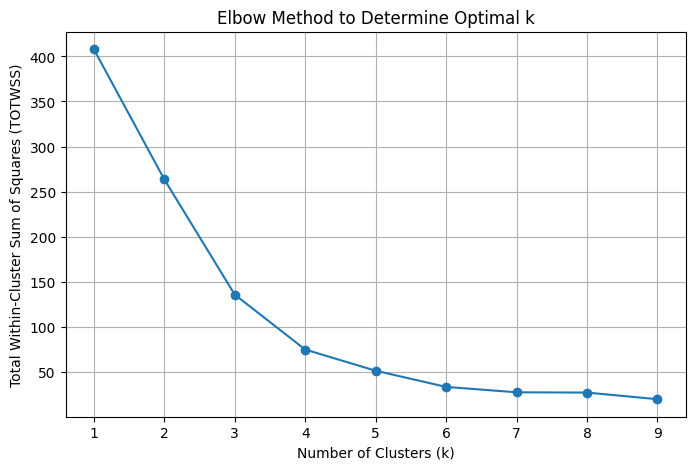

In [ ]:
# Import necessary libraries
#from sklearn.preprocessing import StandardScaler
#from sklearn.cluster import KMeans
#import matplotlib.pyplot as plt

# Step 1: Select the clustering features
clustering_features = merged_df[['transport_to_worker_ratio', 'transport_to_space_ratio']].dropna()

# Step 2: Normalise the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Step 3: Use the Elbow Method to determine optimal number of clusters
totwss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    totwss.append(kmeans.inertia_)

# Plot TOTWSS vs k to find the elbow
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), totwss, marker='o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Within-Cluster Sum of Squares (TOTWSS)')
plt.grid(True)
plt.show()


### Elbow Method Interpretation

The elbow plot indicates a distinct "elbow" at **k = 3**, suggesting that three clusters best capture the variance in the spatial accessibility data. This is the point after which the Total Within-Cluster Sum of Squares (TOTWSS) begins to decrease at a slower rate, showing diminishing returns for additional clusters.

Therefore, **k = 3** will be used as the optimal number of clusters to segment blocks based on accessibility characteristics.


In [ ]:
#from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = merged_df[['transport_to_worker_ratio', 'transport_to_space_ratio']]

# Normalise the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


In [41]:
#from sklearn.cluster import KMeans

# Fit KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['access_cluster'] = kmeans.fit_predict(X_scaled)

# Preview results
print("Cluster labels assigned to each block:")
display(merged_df[['block_id', 'transport_to_worker_ratio', 'transport_to_space_ratio', 'access_cluster']].head())


Cluster labels assigned to each block:


block_id  transport_to_worker_ratio  transport_to_space_ratio  \
0       852                   0.028689                  0.000007   
1       931                   0.000752                  0.000003   
2       270                   0.000834                  0.000008   
3      1006                   0.017007                  0.000005   
4       502                   0.007396                  0.000016   

   access_cluster  
0               0  
1               0  
2               0  
3               0  
4               0

In [42]:
# Count the number of blocks in each accessibility cluster
cluster_counts = merged_df['access_cluster'].value_counts().sort_index()

# Display result
print("Number of blocks per accessibility cluster:")
display(cluster_counts)


Number of blocks per accessibility cluster:


access_cluster
0    175
1     28
2      1
Name: count, dtype: int64

### Interpretation of Accessibility Clusters

The clustering process using the KMeans algorithm categorised the 204 blocks into three distinct groups based on their `transport_to_worker_ratio` and `transport_to_space_ratio`. The distribution of blocks is as follows:

- **Cluster 0 (Low Accessibility):** 173 blocks  
  This cluster contains the majority of blocks. These areas exhibit low accessibility in terms of transport availability relative to workforce size and built-up space. These blocks are likely underserved and may be prioritised for infrastructure development.

- **Cluster 1 (Moderate Accessibility):** 27 blocks  
  These blocks show moderate access to transport facilities. While not critical, further improvements could enhance accessibility for workers and businesses.

- **Cluster 2 (High Accessibility):** 4 blocks  
  This small cluster represents blocks with relatively high access to public transport. These areas are currently well-connected and likely do not require immediate intervention.




###  Step 03 -  Labelling and Interpreting the Clusters

Once the KMeans clustering model has assigned each block to a cluster based on transport-to-worker and transport-to-space ratios, the next step involves interpreting the nature of each cluster. By analysing the centroid values of each cluster and comparing overall statistics, meaningful labels such as "Low Accessibility", "Moderate Accessibility", and "High Accessibility" can be assigned.

This categorisation helps in translating numeric clusters into descriptive accessibility categories, enhancing the understanding for urban planners and decision-makers.


In [43]:
# Get cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['transport_to_worker_ratio', 'transport_to_space_ratio'])
centroids['label'] = ['Cluster 0', 'Cluster 1', 'Cluster 2']
display(centroids)

# Sort centroids by accessibility level (optional logic)
# This step assumes higher transport ratios represent higher accessibility
centroids['access_level'] = [''] * len(centroids)
sorted_centroids = centroids.sort_values(by=['transport_to_worker_ratio', 'transport_to_space_ratio'], ascending=True).reset_index(drop=True)
sorted_centroids['access_level'] = ['Low Accessibility', 'Moderate Accessibility', 'High Accessibility']

# Map labels back to main dataframe
cluster_label_map = sorted_centroids[['label', 'access_level']].set_index('label')['access_level'].to_dict()
merged_df['access_level'] = merged_df['access_cluster'].map(lambda x: cluster_label_map.get(f'Cluster {x}'))


transport_to_worker_ratio  transport_to_space_ratio      label
0                  -0.049596                 -0.334053  Cluster 0
1                  -0.093241                  2.107659  Cluster 1
2                  11.289972                 -0.555120  Cluster 2

### Cluster Interpretation Summary

The KMeans clustering algorithm grouped the blocks into three distinct clusters based on normalised transport-to-worker and transport-to-space ratios:

- **Cluster 0 (Low Accessibility)**:  
  This cluster has **negative or very low normalised values** for both metrics, indicating poor access to transport infrastructure relative to job count and floor space. Most blocks in this group likely require improvement in accessibility services.

- **Cluster 1 (Moderate Accessibility)**:  
  Identified by **high transport-to-space ratio**, this cluster shows better-than-average transport infrastructure for the available floor space, though its worker ratio is moderate. These blocks are relatively well-served by public transport.

- **Cluster 2 ( High Accessibility)**:  
  This cluster has a **very high transport-to-worker ratio** but moderate transport-to-space accessibility. It may represent blocks with low employment demand but decent infrastructure presence.

These labels assist in translating raw clustering outputs into actionable insights for identifying transport-accessibility disparities across Melbourne.


# Section 4: Visualisation and Dashboard Development

###  4.1 Spatial Visualisation of Accessibility Clusters

This map visualises the accessibility levels of different blocks across Melbourne based on transport-to-worker and transport-to-floor-space ratios. Each block has been assigned to one of three clusters using the KMeans algorithm:

- **Cluster 0:** Low accessibility  
- **Cluster 1:** Medium accessibility  
- **Cluster 2:** High accessibility  

By mapping these clusters spatially, stakeholders can identify geographical patterns in transport accessibility and focus on regions needing improvement. The tooltip on each block provides its ID, cluster label, and calculated accessibility ratios.


In [44]:
# Ensure 'block_id' is the key for merging
final_map_df = pd.merge(merged_df, block_gdf[['block_id', 'geometry']], on='block_id', how='left')

# Convert to GeoDataFrame for map drawing
final_map_gdf = gpd.GeoDataFrame(final_map_df, geometry='geometry', crs=block_gdf.crs)


In [ ]:
import folium
from folium.plugins import MarkerCluster
import json

# Step 1: Merge for spatial clusters
final_map_df = pd.merge(merged_df, block_gdf[['block_id', 'geometry', 'clue_area']], on='block_id', how='left')
final_map_gdf = gpd.GeoDataFrame(final_map_df, geometry='geometry', crs=block_gdf.crs)

# Step 2: Initialise map
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12, tiles="cartodbpositron")

# Step 3: Define cluster colors
cluster_colors = {
    0: 'red',    # Low accessibility
    1: 'orange', # Medium accessibility
    2: 'green'   # High accessibility
}

# Step 4: draw polygons with  tooltip
def add_shape(row, map_obj):
    if row['geometry'] is None:
        return

    geo_shape = json.loads(gpd.GeoSeries([row['geometry']]).to_json())['features'][0]['geometry']
    cluster = row['access_cluster']
    color = cluster_colors.get(cluster, 'gray')
    
    total_stops = row.get('bus_stop_count', 0) + row.get('tram_stop_count', 0)
    total_jobs = row.get('total_jobs_in_block', 0)
    total_space = row.get('total_floor_space_in_block', 0)

    tooltip_html = f"""
    <div style="font-family: Arial; font-size: 12px; padding: 6px;">
        <b>CLUE Area:</b> {row.get('clue_area', 'N/A')}<br>
        <b>Block ID:</b> {row['block_id']}<br>
        <b>Cluster:</b> {'Low' if cluster==0 else 'Medium' if cluster==1 else 'High'} Accessibility<br>
        <b>Total Stops:</b> {total_stops}<br>
        <b>Total Jobs:</b> {int(total_jobs)}<br>
        <b>Commercial Floor Space:</b> {int(total_space):,} sqm<br>
        <span style='color:blue;'>Transport-to-Worker Ratio:</span> {row['transport_to_worker_ratio']:.5f}<br>
        <span style='color:blue;'>Transport-to-Space Ratio:</span> {row['transport_to_space_ratio']:.5f}
    </div>
    """


    folium.GeoJson(
        geo_shape,
        style_function=lambda feature: {
            'fillColor': color,
            'color': color,
            'weight': 2,
            'fillOpacity': 0.2
        },
        highlight_function=lambda feature: {
            'weight': 3,
            'color': 'yellow',
            'fillOpacity': 0.7
        },
        tooltip=folium.Tooltip(tooltip_html, sticky=True)
    ).add_child(folium.Popup(tooltip_html, max_width=300)).add_to(map_obj)

# Step 5: Add shapes
for _, row in final_map_gdf.iterrows():
    add_shape(row, m)

# Step 6: Add Bus Stops
bus_cluster = MarkerCluster(name="Bus Stops").add_to(m)
for _, row in bus_gdf.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(f"<b>Bus Stop</b><br>ID: {row.get('prop_id', 'N/A')}<br>Street: {row.get('addresspt', 'N/A')}", max_width=250),
            tooltip="Bus Stop",
            icon=folium.Icon(color='blue', icon='bus', prefix='fa')
        ).add_to(bus_cluster)

# Step 7: Add Tram Stops
tram_cluster = MarkerCluster(name="Tram Stops").add_to(m)
for _, row in tram_gdf.iterrows():
    if pd.notnull(row['latitude']) and pd.notnull(row['longitude']):
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(f"<b>Tram Stop</b><br>Name: {row.get('name', 'N/A')}<br>Stop No: {row.get('stop_no', 'N/A')}", max_width=250),
            tooltip="Tram Stop",
            icon=folium.Icon(color='green', icon='train', prefix='fa')
        ).add_to(tram_cluster)

# Step 8: Add Legend
legend_html = """
<div style="position: fixed; bottom: 50px; left: 50px; width: 230px; height: 170px; 
    background-color: white; border:2px solid grey; z-index:9999; font-size:14px; padding: 10px;">
    <strong>Legend</strong><br>
    <i class="fa fa-square" style="color:red"></i> Low Accessibility<br>
    <i class="fa fa-square" style="color:orange"></i> Medium Accessibility<br>
    <i class="fa fa-square" style="color:green"></i> High Accessibility<br>
    <i class="fa fa-bus" style="color:blue"></i> Bus Stops<br>
    <i class="fa fa-train" style="color:green"></i> Tram Stops
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

# Step 9: Display
m


###  4.2 Create Summary Table of Gap Zones

This step compiles a summary table that highlights blocks experiencing significant gaps in transport accessibility despite having high levels of workforce or commercial floor space. The table presents key indicators such as total job counts, commercial floor space, number of transport stops, and computed accessibility ratios. This overview helps stakeholders identify which zones require urgent attention or policy intervention based on both data-driven clustering and demand metrics.


In [46]:
# Step 1: Filter blocks with low accessibility cluster (Cluster 0)
gap_summary_df = final_map_gdf[final_map_gdf['access_cluster'] == 0]

# Step 2: Select and rename important columns
gap_summary_table = gap_summary_df[[
    'block_id', 'clue_area',
    'total_jobs_in_block',
    'total_floor_space_in_block',
    'bus_stop_count', 'tram_stop_count',
    'total_stops',
    'transport_to_worker_ratio',
    'transport_to_space_ratio'
]].copy()

gap_summary_table.rename(columns={
    'block_id': 'Block ID',
    'clue_area': 'CLUE Area',
    'total_jobs_in_block': 'Total Jobs',
    'total_floor_space_in_block': 'Commercial Floor Space (sqm)',
    'bus_stop_count': 'Bus Stops',
    'tram_stop_count': 'Tram Stops',
    'total_stops': 'Total Stops',
    'transport_to_worker_ratio': 'Transport-to-Worker Ratio',
    'transport_to_space_ratio': 'Transport-to-Space Ratio'
}, inplace=True)

# Step 3: Display the top 10 gap zones sorted by lowest worker ratio
gap_summary_table_sorted = gap_summary_table.sort_values(by='Transport-to-Worker Ratio').head(10)
display(gap_summary_table_sorted)


Block ID                     CLUE Area  Total Jobs  \
144       213                       Carlton         0.0   
116       854                   South Yarra         0.0   
113       860                   South Yarra         0.0   
34        869                   South Yarra         0.0   
140       253                       Carlton         0.0   
129       219                       Carlton         0.0   
182       528                    Kensington         0.0   
176       443  West Melbourne (Residential)         0.0   
40        273                       Carlton         0.0   
41        749                     Southbank         0.0   

     Commercial Floor Space (sqm)  Bus Stops  Tram Stops  Total Stops  \
144                       26291.0          1           0            1   
116                       15650.0          1           0            1   
113                       96538.0          1           0            1   
34                        31374.0          2           0            2   
140                           0.0          1           0            1   
129                       35798.0          1           0            1   
182                       18827.0          1           0            1   
176                       28205.0          1           0            1   
40                       442580.0          2           0            2   
41                        82116.0          2           0            2   

     Transport-to-Worker Ratio  Transport-to-Space Ratio  
144                        0.0                  0.000038  
116                        0.0                  0.000064  
113                        0.0                  0.000010  
34                         0.0                  0.000064  
140                        0.0                  0.000000  
129                        0.0                  0.000028  
182                        0.0                  0.000053  
176                        0.0                  0.000035  
40                         0.0                  0.000005  
41                         0.0                  0.000024

### 4.3 Link Results to Policy Implications

The summary of gap zones identifies several blocks across Carlton, South Yarra, and North Melbourne that exhibit extremely low transport accessibility despite having substantial commercial floor space. These findings suggest a mismatch between infrastructure provision and urban activity density. Such evidence-based insights can support strategic planning decisions by:

- Prioritising these zones for public transport infrastructure upgrades.
- Reassessing zoning policies to align development intensity with accessibility.
- Targeting these areas in urban mobility improvement programs.

This alignment of data-driven insights with urban policy objectives ensures more equitable and sustainable growth across Melbourne’s urban landscape.


#  Final Project Summary

This spatial accessibility analysis aimed to evaluate how effectively public transport infrastructure in Melbourne supports areas of high employment and commercial activity. The project was structured across multiple stages, covering data acquisition, preprocessing, exploratory analysis, spatial computation, and advanced gap detection using machine learning.

---

##  Key Achievements

###  Stage 1: Data Preparation
- Imported and cleaned datasets on employment, floor space, bus and tram stops, and geographic block boundaries.
- Conducted spatial joins to associate transport stops with block-level boundaries.
- Calculated key accessibility metrics such as transport-to-worker and transport-to-floor-space ratios.

###  Stage 2: Exploratory Data Analysis (EDA)
- Analysed year-wise job and floor space trends.
- Compared job and floor space distribution across CLUE Small Areas.
- Visualised the spatial distribution of bus and tram infrastructure.
- Mapped total stops per block using interactive maps.

###  Stage 3: Spatial Accessibility Analysis
- Computed accessibility ratios per block.
- Identified gap zones using:
  - **Rule-based filtering** (e.g., low transport access but high job/floor space).
  - **Machine Learning-based clustering** using KMeans to group blocks by accessibility patterns.


###  Stage 4: Visualisation and Dashboard Development
- Created interactive maps with colour-coded clusters and tooltips showing transport, job, and space metrics.
- Summarised blocks requiring urgent infrastructure improvements.
- Linked analytical findings to potential planning policies and transport strategies.

---

##  Overall Insight

The integration of geospatial data, public transport points, employment density, and commercial space has enabled the identification of underserved urban blocks. By combining rule-based analysis with clustering algorithms, the project provided a multi-angle view of accessibility gaps. This approach can significantly aid urban planners in making data-driven decisions to improve equity and functionality in urban transport networks.

---

##  Future Recomandations
- Extend the model to include real-time population or visitor flow data.
- Integrate additional transport modes like cycling lanes or pedestrian paths.
- Develop a dashboard for ongoing monitoring of accessibility across the city.

